# **Face Recognition with Super-Resolution**

**Abstract** - In this project we explore super-resolution techniques in order to enhance images of faces acquired by a camera with a very low resolution or from a long distance. Our hypothesis is that increasing the images resolution, we can leverage more information and build a model which can perform better in the face recognition task w.r.t. a model which uses the low resolution images. We describe and evaluate several methods to perform the upscaling and compare them with a base model without using super-resolution. Moreover, we propose and test two models, which are Generative Adversarial Networks (GANs), able to perform upscaling from images with a resolution lower than the one used by the most popular state-of-the-art models.

# Initialization

In this section we upgrade OpenCV and import the required libraries.

In [ ]:
!pip -q install opencv-contrib-python --upgrade

     |████████████████████████████████| 66.5 MB 113 kB/s 


In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

import os
import time
from datetime import datetime
import json
import shutil
from typing import *

from google_drive_downloader import GoogleDriveDownloader as gdd

In [ ]:
#@title Utils functions

def get_progress_bar(value: int, total: int, len=20):
  progress = value * len // total
  remaining = len - progress
  progress_str = "=" * progress
  remaining_str = " " * remaining
  return "[" + progress_str + remaining_str + "]"

def download_dataset(name: str, gdrive_id: str, unzip=True):
  if os.path.isfile(name):
    print("{} already downloaded.".format(name))
    return

  gdd.download_file_from_google_drive(file_id=gdrive_id, dest_path="/content/" + name, unzip=unzip)

def download_datasets(names_dict: Dict[str, str], unzip=True):
  for name, gdrive_id in names_dict.items():
    download_dataset(name, gdrive_id, unzip)

# Read dataset

In this section we load all the datasets used in the project.

## CASIA WebFace

In [ ]:
#@title Download dataset

download_dataset("CASIA-WebFace.zip", "1Of_EVz-yHV7QVWQGihYfvtny9Ne8qXVz")

In [ ]:
webface = tf.keras.preprocessing.image_dataset_from_directory("CASIA-WebFace", image_size=(250, 250), shuffle=False)

In [ ]:
#@title Dataset samples

images, labels = next(iter(webface))
image = images[0]
label = labels[0]

print("=== Inspect Dataset Format ===")
print("Image Shape:", image.shape)
print("Label example:", label.numpy())
print("Min value:", np.min(images))
print("Max value:", np.max(images))
print()

plt.figure(figsize=(10, 10))
for images, labels in webface.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(webface.class_names[labels[i]])
    plt.axis("off")

## Labeled Faces in the Wild

In [ ]:
#@title Download dataset
!wget -nc -q --show-progress http://vis-www.cs.umass.edu/lfw/lfw.tgz
# Extract the archive
!tar -xf lfw.tgz

lfw.tgz             100%[===================>] 172.20M  54.3MB/s    in 3.5s    


In [ ]:
lfw = tf.keras.utils.image_dataset_from_directory("lfw", image_size=(250, 250), shuffle=False)

Found 13233 files belonging to 5749 classes.


=== Inspect Dataset Format ===
Image Shape: (250, 250, 3)
Label example: 0
Min value: 0.0
Max value: 255.0



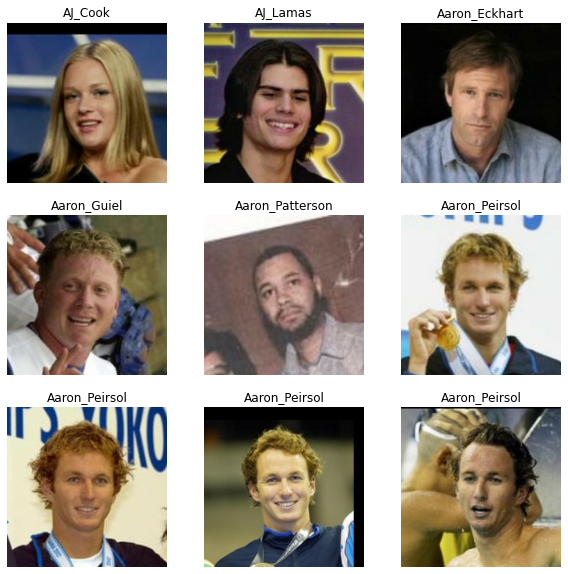

In [ ]:
#@title Dataset samples

images, labels = next(iter(lfw))
image = images[0]
label = labels[0]

print("=== Inspect Dataset Format ===")
print("Image Shape:", image.shape)
print("Label example:", label.numpy())
print("Min value:", np.min(images))
print("Max value:", np.max(images))
print()

plt.figure(figsize=(10, 10))
for images, labels in lfw.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(lfw.class_names[labels[i]])
    plt.axis("off")

# Face Localization

The first real module of our architecture is used in order to extract faces from the images of the datasets.
In our implementation we tried to use two different techniques: we first used the Haar Cascade classifier implemented in OpenCV following the Viola-Jones algorithm, and then we also tried the Multi-Task Cascaded Convolutional Neural Network (MTCNN) model.

In [ ]:
def crop_face(image: np.ndarray, x: int, y: int, width: int, height: int, dim=(100, 100)):
  image = image[y : y + height, x : x + width]
  return cv.resize(image, dim)

## Haar Cascade Classifier

In [ ]:
!wget -nc -q --show-progress https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

In [ ]:
face_cascade = cv.CascadeClassifier("haarcascade_frontalface_default.xml")

def haar_localize_face(image: tf.Tensor, dim=(100, 100)):
  """ Localize a face in the image and crop the image in a way that contains only the found face. """
  numpy_img = image.numpy().astype(np.uint8)
  faces, _, confidence = face_cascade.detectMultiScale3(numpy_img, 1.05, 4, outputRejectLevels=True)

  if len(faces) != 0:
    # Take the face with the highest confidence
    x, y, w, h = faces[np.argmax(confidence)]

    return crop_face(numpy_img, x, y, w, h, dim)
  return None

## Multi-Task Cascaded Convolutional Neural Network (MTCNN)

In [ ]:
!pip -q install mtcnn

     |████████████████████████████████| 2.3 MB 13.0 MB/s 


In [ ]:
from mtcnn.mtcnn import MTCNN
detector = MTCNN()

def mtcnn_localize_face(image: tf.Tensor, dim=(100, 100)):
  numpy_img = image.numpy()
  results = detector.detect_faces(numpy_img)

  x, y, w, h = results[0]["box"]
  
  return crop_face(numpy_img, x, y, w, h, dim)

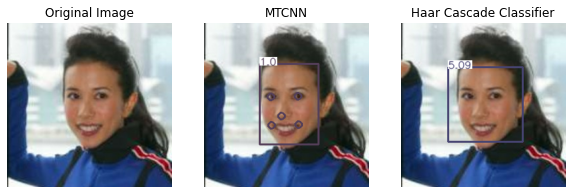

In [ ]:
#@title Compare Face Localization Models

images, labels = next(iter(lfw))
image = images[0]
numpy_img = image.numpy()

plt.figure(figsize=(10, 8))
plt.subplot(1, 3, 1)
plt.axis("off")
plt.title("Original Image")
plt.imshow(image.numpy().astype(np.uint8))

mtcnn_image = numpy_img.copy().astype(np.uint8)
results = detector.detect_faces(numpy_img)

for result in results:
  conf = result["confidence"]
  x, y, w, h = result['box']
  color = (int(x % 255), int(y % 255), int(w % 255))

  for keypoint in result["keypoints"].values():
    cv.circle(mtcnn_image, keypoint, radius=5, color=color, thickness=2)

  cv.rectangle(mtcnn_image, (x, y), (x + w, y + h), color, 2)
  
  text_size, _ = cv.getTextSize(str(conf.round(2)), cv.FONT_HERSHEY_SIMPLEX, .5, 1)
  text_w, text_h = text_size
  cv.rectangle(mtcnn_image, (x, y-10), (x + text_w, y + text_h-10), (255, 255, 255), -1)
  cv.putText(mtcnn_image, str(conf.round(2)), (x, y + 2), cv.FONT_HERSHEY_SIMPLEX, .5, color, 1, cv.LINE_AA)

plt.subplot(1, 3, 2)
plt.axis("off")
plt.title("MTCNN")
plt.imshow(mtcnn_image)

haar_image = numpy_img.copy().astype(np.uint8)
faces, _, confidence = face_cascade.detectMultiScale3(haar_image, 1.05, 4, outputRejectLevels=True)
for data, conf in zip(faces, confidence):
  x, y, w, h = data
  color = (int(x % 255), int(y % 255), int(w % 255))
  cv.rectangle(haar_image, (x, y), (x + w, y + h), color, 2)
  text_size, _ = cv.getTextSize(str(conf.round(2).item()), cv.FONT_HERSHEY_SIMPLEX, .5, 1)
  text_w, text_h = text_size
  cv.rectangle(haar_image, (x, y-10), (x + text_w, y + text_h-10), (255, 255, 255), -1)
  cv.putText(haar_image, str(conf.round(2).item()), (x, y + 2), cv.FONT_HERSHEY_SIMPLEX, .5, color, 1, cv.LINE_AA)
plt.subplot(1, 3, 3)
plt.axis("off")
plt.title("Haar Cascade Classifier")
plt.imshow(haar_image)
plt.show()

### Test cropped faces

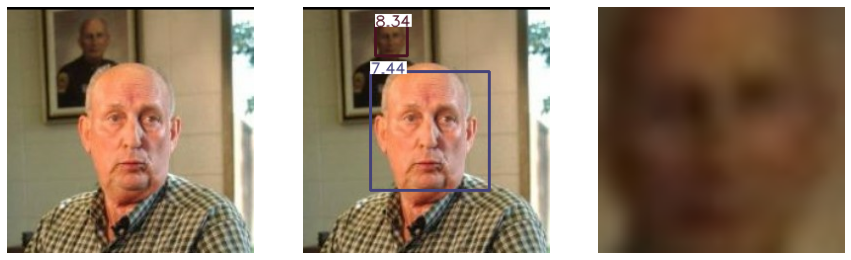

In [ ]:
dataset = lfw
# image = next(iter(dataset))[0][0]
cropped_image = crop_face(image)
numpy_img = image.numpy().astype(np.uint8)

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
axs[0].axis("off")
axs[0].imshow(numpy_img)

faces, _, confidence = face_cascade.detectMultiScale3(numpy_img, 1.05, 4, outputRejectLevels=True)
for data, conf in zip(faces, confidence):
  x, y, w, h = data
  color = (int(x % 255), int(y % 255), int(w % 255))
  cv.rectangle(numpy_img, (x, y), (x + w, y + h), color, 2)
  text_size, _ = cv.getTextSize(str(conf.round(2).item()), cv.FONT_HERSHEY_SIMPLEX, .5, 1)
  text_w, text_h = text_size
  cv.rectangle(numpy_img, (x, y-10), (x + text_w, y + text_h-10), (255, 255, 255), -1)
  cv.putText(numpy_img, str(conf.round(2).item()), (x, y + 2), cv.FONT_HERSHEY_SIMPLEX, .5, color, 1, cv.LINE_AA)
axs[1].axis("off")
axs[1].imshow(numpy_img)

if cropped_image is not None:
  axs[2].axis("off")
  axs[2].imshow(cropped_image)

plt.show()

## Crop Datasets

In [ ]:
MODEL = "Haar" #@param ["Haar", "MTCNN"]

crop_face = haar_localize_face if MODEL == "Haar" else mtcnn_localize_face

In [ ]:
def crop_faces_to_disk(dataset: tf.Dataset, dim=(100, 100), save_dir="cropped"):
  """ Localize a face and crop the image of an entire dataset. """
  total_size = len(dataset.file_paths)

  # Remove previous directory if exists
  if os.path.exists(save_dir):
    import shutil
    shutil.rmtree(save_dir)
  
  os.mkdir(save_dir)

  i = 0
  successfully_cropped = 0
  for images, labels in dataset:
    cropped_images = []

    # Crop images for a batch
    for image, label in zip(images, labels):
      if i % 10 == 0:
        progress_bar = get_progress_bar(i, total_size)
        percent = int(i / total_size * 100)
        print("\r%s%% %s Cropping and saving to disk %d/%d..." % (percent, progress_bar, i, total_size), end="")

      cropped_image = crop_face(image, dim)
      if cropped_image is not None:
        cropped_images.append(cropped_image)
        successfully_cropped += 1

        image_path = dataset.file_paths[i]
        orig_folder = os.path.basename(os.path.dirname(image_path))
        path = os.path.join(save_dir, orig_folder)
        if not os.path.exists(path):
          os.makedirs(path)
        
        filename = os.path.basename(image_path)
        cropped_image = cv.cvtColor(cropped_image, cv.COLOR_RGB2BGR)
        cv.imwrite(os.path.join(path, filename), cropped_image)
      
      i += 1

  progress_bar = get_progress_bar(len(dataset), len(dataset))
  print("\r%s%% %s Cropped with success %d images of %d" % (100, progress_bar, successfully_cropped, total_size))

#### CASIA-WebFace

In [ ]:
crop_faces_to_disk(webface, dim=(128, 128), save_dir="cropped-webface-128")

In [ ]:
crop_faces_to_disk(webface, dim=(32, 32), save_dir="cropped-webface-32")

#### LFW

In [ ]:
crop_faces_to_disk(lfw, dim=(128, 128), save_dir="cropped-lfw-128")

In [ ]:
crop_faces_to_disk(lfw, dim=(32, 32), save_dir="cropped-lfw-32")

# Load cropped dataset

In this section we can load the dataset already cropped in the previous section.

## CASIA-WebFace

In [ ]:
#@title Download 128x128 dataset

# download_dataset("./cropped-webface-128.zip", "1GDf-WLB6nrziXkuEMXXZ_4BY3UPe8XCW")
download_dataset("./cropped-webface-128_1000.zip", "1PR1Mhi6uUyrVUP5HDmHJvXVQqz-izNJ4")

Unzipping...Done.


In [ ]:
#@title Download 32x32 dataset

# download_dataset("./cropped-webface-32.zip", "1sEruTxp6hZTdiF9k1qPNhAvc93LYdMTh")
download_dataset("./cropped-webface-32_1000.zip", "1gwHNOMbZ2_6VDUYmdO6LQG4OlyKAHTz6")

Unzipping...Done.


In [ ]:
params = { "image_size": (128, 128), "shuffle": True, "validation_split": .2, "seed": 42 }

cropped_webface_train_ds = tf.keras.preprocessing.image_dataset_from_directory("/content/cropped-webface-128_1000", subset="training", **params)
cropped_webface_validate_ds = tf.keras.preprocessing.image_dataset_from_directory("/content/cropped-webface-128_1000", subset="validation", **params)

Found 73809 files belonging to 1000 classes.
Using 59048 files for training.
Found 73809 files belonging to 1000 classes.
Using 14761 files for validation.


In [ ]:
params = { "image_size": (32, 32), "shuffle": True, "validation_split": .2, "seed": 42 }

cropped_webface_small_train_ds = tf.keras.preprocessing.image_dataset_from_directory("/content/cropped-webface-32_1000", subset="training", **params)
cropped_webface_small_validate_ds = tf.keras.preprocessing.image_dataset_from_directory("/content/cropped-webface-32_1000", subset="validation", **params)

Found 73809 files belonging to 1000 classes.
Using 59048 files for training.
Found 73809 files belonging to 1000 classes.
Using 14761 files for validation.


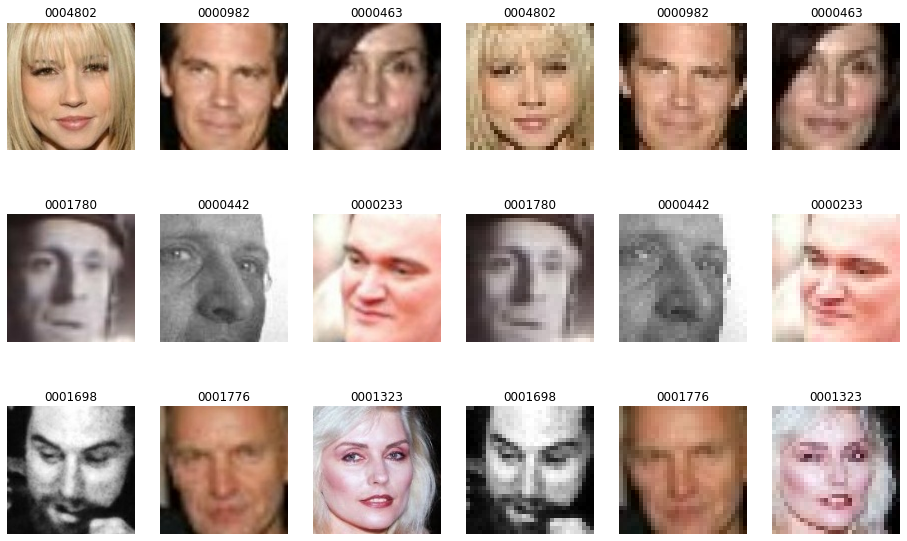

In [ ]:
#@title Dataset samples
#@markdown On the left we have the samples from the dataset 128x128, instead on the right the samples from the dataset 32x32.

plt.figure(figsize=(16, 10))
for images, labels in cropped_webface_validate_ds.take(1):
  for i in range(9):
    index = i + (3 * (i // 3)) + 1
    ax = plt.subplot(3, 6, index)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(cropped_webface_validate_ds.class_names[labels[i]])
    plt.axis("off")

for images, labels in cropped_webface_small_validate_ds.take(1):
  for i in range(9):
    index = 3 + i + (3 * (i // 3)) + 1
    ax = plt.subplot(3, 6, index)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(cropped_webface_small_validate_ds.class_names[labels[i]])
    plt.axis("off")

plt.show()

## LFW

In [ ]:
#@title Download 128x128 dataset

download_dataset("./cropped-lfw-128.zip", "1vl_wEEmQec0hZr45XNBEAS5ZQsKIFhsZ")

Unzipping...Done.


In [ ]:
#@title Download 32x32 dataset

download_dataset("./cropped-lfw-32.zip", "1--4PtbM2BOV7Qly4IPl0BznjKJYXGwhY")

Unzipping...Done.


In [ ]:
cropped_lfw = tf.keras.preprocessing.image_dataset_from_directory("/content/cropped-lfw-128", image_size=(128, 128), shuffle=False, seed=42)

Found 13190 files belonging to 5733 classes.


In [ ]:
cropped_lfw_small = tf.keras.preprocessing.image_dataset_from_directory("/content/cropped-lfw-32", image_size=(32, 32), shuffle=False, seed=42)

Found 13190 files belonging to 5733 classes.


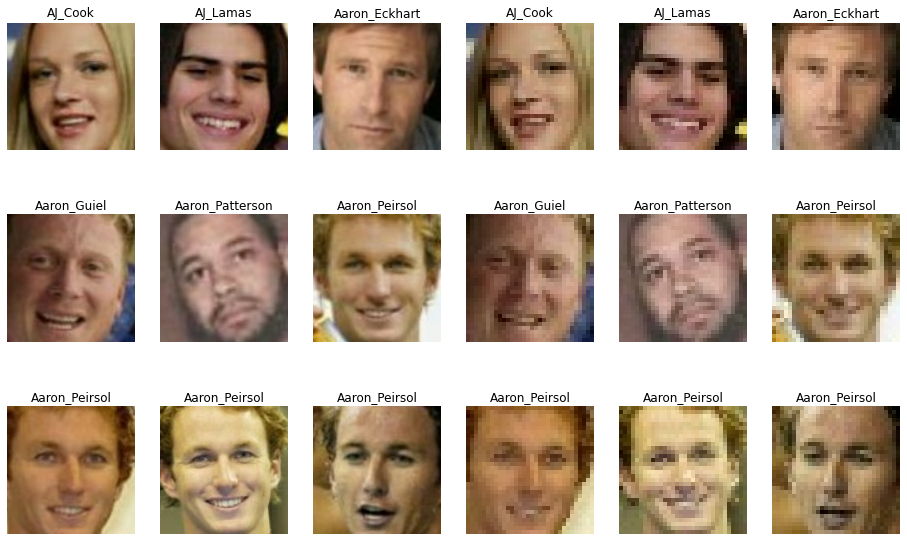

In [ ]:
#@title Dataset samples
#@markdown On the left we have the samples from the dataset 128x128, instead on the right the samples from the dataset 32x32.

plt.figure(figsize=(16, 10))
for images, labels in cropped_lfw.take(1):
  for i in range(9):
    index = i + (3 * (i // 3)) + 1
    ax = plt.subplot(3, 6, index)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(cropped_lfw.class_names[labels[i]])
    plt.axis("off")

for images, labels in cropped_lfw_small.take(1):
  for i in range(9):
    index = 3 + i + (3 * (i // 3)) + 1
    ax = plt.subplot(3, 6, index)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(cropped_lfw_small.class_names[labels[i]])
    plt.axis("off")

plt.show()

# Super-Resolution Module

In this section we will review some super-resolution methods used in the state-of-the-art and implement our own solution.

## EDSR
Based on the OpenCV implementation.

In [ ]:
!wget -nc -q --show-progress https://github.com/Saafke/EDSR_Tensorflow/blob/master/models/EDSR_x4.pb?raw=true -O EDSR_x4.pb

EDSR_x4.pb          100%[===================>]  36.79M   152MB/s    in 0.2s    


In [ ]:
edsr_model = cv.dnn_superres.DnnSuperResImpl_create()
edsr_model.readModel("EDSR_x4.pb")
edsr_model.setModel("edsr", 4)

In [ ]:
def upsample_edsr(image):
  return edsr_model.upsample(image)

## ESRGAN

This model does actually work, but on the [documentation](https://tfhub.dev/captain-pool/esrgan-tf2/1) it says that it should be used with images at least of resolution 64x64, so we cannot use it for our task, since we are going to work with 32x32 images. However, we can still check the result with a 32x32 image.

In [ ]:
import tensorflow_hub as hub

SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
esrgan_model = hub.load(SAVED_MODEL_PATH)

In [ ]:
def upsample_esrgan(image):
  data = tf.expand_dims(tf.cast(image, tf.float32), 0)
  output = esrgan_model(data)
  return tf.cast(tf.clip_by_value(output[0], 0, 255), tf.uint8)

## SRGAN

Based on [this](https://github.com/krasserm/super-resolution) implementation found on GitHub.

In [ ]:
!git clone https://github.com/krasserm/super-resolution super_resolution

Cloning into 'super_resolution'...
remote: Enumerating objects: 405, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 405 (delta 9), reused 19 (delta 8), pack-reused 385
Receiving objects: 100% (405/405), 54.27 MiB | 30.31 MiB/s, done.
Resolving deltas: 100% (209/209), done.


In [ ]:
# Download weights
!wget -nc -q --show-progress https://martin-krasser.de/sisr/weights-srgan.tar.gz
!tar xvfz weights-srgan.tar.gz

weights-srgan.tar.g 100%[===================>]  94.45M  25.6MB/s    in 4.4s    
weights/srgan/gan_discriminator.h5
weights/srgan/gan_generator.h5
weights/srgan/pre_generator.h5


In [ ]:
import sys
sys.path.append("/content/super_resolution")

from model import resolve_single
from model.srgan import generator

srgan_model = generator()
srgan_model.load_weights("weights/srgan/gan_generator.h5")

In [ ]:
def upsample_srgan(image):
  sr = resolve_single(srgan_model, image)
  return sr.numpy().astype(np.uint8)

## Our model

### Dataset Preparation

First of all we prepared the dataset by taking a subset of it since it would take a lot of time to train the model with the entire dataset. We also added an option to filter it by taking only sharp images in order to exclude low-quality images.

In [ ]:
# Just take a certain number of examples from the dataset
#@title Dataset params
train_size = 5000 #@param {type: "integer"}
train_batch = 32 #@param {type: "integer"}
filter_by_quality = True #@param {type: "boolean"}
threshold = 400 #@param {type: "integer"}
#@markdown \\
test_size = 500 #@param {type: "integer"}
test_batch = 32 #@param {type: "integer"}

def get_subdataset(dataset):
  images = []
  labels = []

  for image, label in dataset:
    images.append(image)
    labels.append(label)
  
  return np.array(images), np.array(labels)

def variance_of_laplacian(img):
  """ Compute an estimation of the image quality """
  gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
  return cv.Laplacian(gray, cv.CV_64F).var()

def select_good_images(lr_dataset, hr_dataset, n, th=1000):
  selected_hr_images = []
  selected_lr_images = []
  selected_labels = []

  zipped_datasets = tf.data.Dataset.zip((lr_dataset, hr_dataset))
  for lr_data, hr_data in zipped_datasets:
    lr_img, _ = lr_data
    hr_img, label = hr_data
    
    int_img = hr_img.numpy().astype(np.uint8)
    score = variance_of_laplacian(int_img)
    
    if score > th:
      current = len(selected_hr_images)
      progress_bar = get_progress_bar(current, n)
      print("\r%s%% %s Finding good images %d/%d..." % (int(current/n*100), progress_bar, current, n), end="")
  
      selected_hr_images.append(tf.identity(hr_img))
      selected_lr_images.append(tf.identity(lr_img))
      selected_labels.append(label)
      
      if len(selected_hr_images) == n:
        break
  
  progress_bar = get_progress_bar(n, n)
  print("\r%s%% %s Finding good images %d/%d..." % (int(n/n*100), progress_bar, n, n), end="")

  return np.array(selected_lr_images), np.array(selected_hr_images), selected_labels

# Training dataset
if filter_by_quality:
  small_train_imgs, train_imgs, labels = select_good_images(cropped_webface_small_train_ds.unbatch(), cropped_webface_train_ds.unbatch(), train_size, th=threshold)
else:
  small_train_imgs, labels = get_subdataset(cropped_webface_small_train_ds.unbatch().take(train_size))
  train_imgs, _ = get_subdataset(cropped_webface_train_ds.unbatch().take(train_size))
low_res_train_ds = tf.data.Dataset.from_tensor_slices((small_train_imgs, labels)).shuffle(1024, seed=42).batch(train_batch)
high_res_train_ds = tf.data.Dataset.from_tensor_slices((train_imgs, labels)).shuffle(1024, seed=42).batch(train_batch)
# Precompute training Canny images
canny_train_images = []
for hr in train_imgs:
  canny_hr = cv.Canny(hr.astype(np.uint8), 50, 150)
  canny_train_images.append(canny_hr)
canny_train_images = np.array(canny_train_images, dtype=np.float32)
canny_train_ds = tf.data.Dataset.from_tensor_slices(canny_train_images).shuffle(1024, seed=42).batch(train_batch)

# Test dataset
small_val_images, val_labels = get_subdataset(cropped_webface_small_validate_ds.unbatch().take(test_size))
low_res_test_ds = tf.data.Dataset.from_tensor_slices((small_val_images, val_labels)).shuffle(1024, seed=42).batch(test_batch)
val_images, val_labels = get_subdataset(cropped_webface_validate_ds.unbatch().take(test_size))
high_res_test_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).shuffle(1024, seed=42).batch(test_batch)
# Precompute test Canny images
canny_val_images = []
for hr in val_images:
  canny_hr = cv.Canny(hr.astype(np.uint8), 50, 150)
  canny_val_images.append(canny_hr)
canny_val_images = np.array(canny_val_images, dtype=np.float32)
canny_test_ds = tf.data.Dataset.from_tensor_slices(canny_val_images).shuffle(1024, seed=42).batch(test_batch)

100% [====================] Finding good images 5000/5000...

In [ ]:
def norm_img(img, subtract_mean=True):
  if subtract_mean:
    return ((img - 127.5) / 127.5).numpy().astype(np.uint8)
  else:
    return (img / 255).numpy().astype(np.uint8)

def denorm_img(img, subtract_mean=True):
  if subtract_mean:
    return (img * 127.5 + 127.5).numpy().astype(np.uint8)
  else:
    return (img * 255).numpy().astype(np.uint8)

processed_small_train = low_res_train_ds.map(lambda img, label: (img - 127.5) / 127.5)
processed_train = high_res_train_ds.map(lambda img, label: (img - 127.5) / 127.5)
processed_canny_train = canny_train_ds.map(lambda img: img / 255.0)
train_dataset = tf.data.Dataset.zip((processed_small_train, processed_train))
train_canny_dataset = tf.data.Dataset.zip((processed_small_train, processed_train, processed_canny_train))

processed_small_test = low_res_test_ds.map(lambda img, label: (img - 127.5) / 127.5)
processed_test = high_res_test_ds.map(lambda img, label: (img - 127.5) / 127.5)
processed_canny_test = canny_test_ds.map(lambda img: img / 255.0)
test_dataset = tf.data.Dataset.zip((processed_small_test, processed_test))
test_canny_dataset = tf.data.Dataset.zip((processed_small_test, processed_test, processed_canny_test))

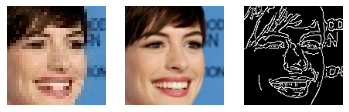

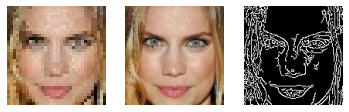

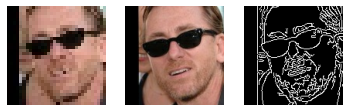

In [ ]:
#@title Train sample

for sr, hr, canny in train_canny_dataset.unbatch().take(3):
  plt.subplot(1, 3, 1)
  plt.axis("off")
  plt.imshow(denorm_img(sr))

  plt.subplot(1, 3, 2)
  plt.axis("off")
  plt.imshow(denorm_img(hr))

  plt.subplot(1, 3, 3)
  plt.imshow(denorm_img(canny), cmap="gray")
  plt.axis("off")
  plt.show()

### Model Creation

In [ ]:
#@title Model definition

class MySubpixelConv2D(Layer):
  def __init__(self, upsampling_factor=4, **kwargs):
    super().__init__(**kwargs)
    self.upsampling_factor = upsampling_factor

  def call(self, inputs):
    return tf.nn.depth_to_space(inputs, self.upsampling_factor)

class UpsamplingGAN():
  def __init__(self,
               content_loss_weight=1,
               adversarial_loss_weight=1,
               lr=1e-4,
               inspect_train_image=None,
               inspect_test_image=None,
               inspect_image_steps=200,
               autosave=10,
               autosave_dir=".",
               weights=None):
    self.inspect_image_steps = inspect_image_steps
    self.inspect_train_image = inspect_train_image
    self.inspect_test_image = inspect_test_image

    self.autosave = autosave
    self.autosave_dir = autosave_dir

    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    train_log_dir = "logs/gradient_tape/" + current_time + "/train"
    test_log_dir = "logs/gradient_tape/" + current_time + "/test"
    self.train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    self.test_summary_writer = tf.summary.create_file_writer(test_log_dir)

    self.generator = self.__make_generator()
    if weights:
      self.generator.load_weights(os.path.join(weights, "generator_weights"))

    # Remove batch size from shape
    generator_output_shape = self.generator.output_shape[1:]
    self.discriminator = self.__make_discriminator(generator_output_shape)
    if weights:
      self.discriminator.load_weights(os.path.join(weights, "discriminator_weights"))

    # Define loss
    self.cross_entropy = tf.keras.losses.BinaryCrossentropy()
    self.mse = tf.keras.losses.MeanSquaredError()
    self.content_loss_weight = content_loss_weight
    self.adversarial_loss_weight = adversarial_loss_weight

    # Define optimizers
    self.generator_optimizer = tf.keras.optimizers.Adam(lr)
    self.discriminator_optimizer = tf.keras.optimizers.Adam(lr)

  def __make_generator(self):
    inputs = tf.keras.Input(shape=(None, None, 3))
    x = Conv2D(64, (9, 9), strides=(1, 1), padding="same")(inputs)
    x_temp2 = LeakyReLU()(x)
    x_temp = x_temp2

    # Block 1
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x_temp)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x_temp = Add()((x_temp, x))

    # Block 2
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x_temp)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x_temp = Add()((x_temp, x))

    # Block 3
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x_temp)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x_temp = Add()((x_temp, x))

    # Block 4
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x_temp)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x_temp = Add()((x_temp, x))

    # Block 5
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x_temp)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = Add()((x_temp, x))

    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = Add()((x_temp2, x))

    x = Conv2D(256, (3, 3), strides=(1, 1), padding="same")(x)
    x = MySubpixelConv2D(upsampling_factor=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, (3, 3), strides=(1, 1), padding="same")(x)
    x = MySubpixelConv2D(upsampling_factor=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(3, (9, 9), strides=(1, 1), padding="same", activation="tanh")(x)

    model = tf.keras.Model(inputs, x, name="generator")
    return model

  def __make_discriminator(self, input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(inputs)
    x = LeakyReLU()(x)

    x = Conv2D(64, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(128, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(128, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Dense(1024)(x)
    x = LeakyReLU()(x)
    x = Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, x, name="discriminator")
    return model
  
  def generator_loss(self, fake_output):
    return self.cross_entropy(tf.ones_like(fake_output), fake_output)

  def discriminator_loss(self, real_output, fake_output):
    real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

  @tf.function
  def train_step(self, lr, sr):
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = self.generator(lr, training=True)

        real_output = self.discriminator(sr, training=True)
        fake_output = self.discriminator(generated_images, training=True)

        # Compute loss
        content_loss = self.content_loss_weight * self.mse(sr, generated_images)

        gen_loss = self.adversarial_loss_weight * self.generator_loss(fake_output)
        disc_loss = self.discriminator_loss(real_output, fake_output)

        perc_loss = content_loss + gen_loss

      gradients_of_generator = gen_tape.gradient(perc_loss, self.generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

      self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
      self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

      return perc_loss, disc_loss

  @tf.function
  def test_step(self, lr, sr):
    generated_images = self.generator(lr, training=False)

    real_output = self.discriminator(sr, training=False)
    fake_output = self.discriminator(generated_images, training=False)

    # Compute loss
    content_loss = self.content_loss_weight * self.mse(sr, generated_images)

    gen_loss = self.adversarial_loss_weight * self.generator_loss(fake_output)
    disc_loss = self.discriminator_loss(real_output, fake_output)

    perc_loss = content_loss + gen_loss

    return perc_loss, disc_loss

  def fit(self, dataset, validate_dataset, epochs):
    losses = {"loss": [], "val_loss": [], "perc_loss": [], "disc_loss": [], "val_perc_loss": [], "val_disc_loss": []}

    dataset_size = len(dataset)
    validate_dataset_size = len(validate_dataset)

    train_start_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    step_count = 0
    lrs, srs = next(iter(dataset))
    train_img = self.inspect_train_image or (lrs[0], srs[0])
    lrs, srs = next(iter(validate_dataset))
    test_img = self.inspect_test_image or (lrs[0], srs[0])

    train_subset = list(dataset.unbatch().take(5))
    test_subset = list(validate_dataset.unbatch().take(5))

    best_val_loss = None
    weights_dir = "weights-" + train_start_time

    for epoch in range(epochs):
      print("Epoch %d/%d" % (epoch + 1, epochs))
      total_perc_loss = 0
      total_disc_loss = 0
      
      epoch_start = time.time()
      elapsed_time = 0
      step_elapsed_time = 0

      for batch, data in enumerate(dataset):
        step_start = time.time()
        step_count += 1

        # Save image for inspection
        if step_count % self.inspect_image_steps == 0:
          self._save_inspect_image(step_count, train_img, test_img)

        lr, sr = data
        perc_loss, disc_loss = self.train_step(lr, sr)

        total_perc_loss += perc_loss
        total_disc_loss += disc_loss
        loss = total_perc_loss + total_disc_loss

        step_end = time.time()
        elapsed_time = datetime.fromtimestamp(step_end - epoch_start).strftime("%s")
        step_elapsed_time = .5 * step_elapsed_time + .5 * (step_end - step_start)

        progress_bar = get_progress_bar(batch, dataset_size)
        print("\r%d/%d %s - %ss %dms/step - loss: %.3f - perc_loss: %.3f - disc_loss: %.3f" % (batch + 1, dataset_size, progress_bar, elapsed_time, step_elapsed_time * 1000, loss / dataset_size, total_perc_loss / dataset_size, total_disc_loss / dataset_size), end="")

      total_perc_loss = total_perc_loss / dataset_size
      total_disc_loss = total_disc_loss / dataset_size
      loss = total_perc_loss + total_disc_loss

      losses["perc_loss"].append(total_perc_loss.numpy())
      losses["disc_loss"].append(total_disc_loss.numpy())
      losses["loss"].append(loss.numpy())

      progress_bar = get_progress_bar(dataset_size, dataset_size)
      print("\r%d/%d %s - %ss %dms/step - loss: %.3f - perc_loss: %.3f - disc_loss: %.3f" % (dataset_size, dataset_size, progress_bar, elapsed_time, step_elapsed_time * 1000, loss, total_perc_loss, total_disc_loss), end="")
  
      with self.train_summary_writer.as_default():
        tf.summary.scalar("loss", loss, step=epoch)
        tf.summary.scalar("perc_loss", total_perc_loss, step=epoch)
        tf.summary.scalar("disc_loss", total_disc_loss, step=epoch)

      total_val_perc_loss = 0
      total_val_disc_loss = 0

      for batch, val_data in enumerate(validate_dataset):
        lr, sr = val_data
        perc_loss, disc_loss = self.test_step(lr, sr)

        total_val_perc_loss += perc_loss
        total_val_disc_loss += disc_loss
      
      total_val_perc_loss = total_val_perc_loss / validate_dataset_size
      total_val_disc_loss = total_val_disc_loss / validate_dataset_size
      val_loss = total_val_perc_loss + total_val_disc_loss

      losses["val_perc_loss"].append(total_val_perc_loss.numpy())
      losses["val_disc_loss"].append(total_val_disc_loss.numpy())
      losses["val_loss"].append(val_loss.numpy())

      elapsed_time = datetime.fromtimestamp(time.time() - epoch_start).strftime("%s")
      progress_bar = get_progress_bar(dataset_size, dataset_size)
      
      print("\r%d/%d %s - %ss %dms/step - loss: %.3f - perc_loss: %.3f - disc_loss: %.3f - val_loss: %.3f - val_perc_loss: %.3f - val_disc_loss: %.3f" % (dataset_size, dataset_size, \
                                  progress_bar, elapsed_time, \
                                  step_elapsed_time * 1000, loss, \
                                  total_perc_loss, \
                                  total_disc_loss, \
                                  val_loss, \
                                  total_val_perc_loss, \
                                  total_val_disc_loss), end="\n")

      with self.test_summary_writer.as_default():
        tf.summary.scalar("val_loss", val_loss, step=epoch)
        tf.summary.scalar("val_perc_loss", total_val_perc_loss, step=epoch)
        tf.summary.scalar("val_disc_loss", total_val_disc_loss, step=epoch)

      # Save best weights until now
      if not best_val_loss or val_loss < best_val_loss:
        best_val_loss = val_loss
        self.save_weights(dir=weights_dir)

      # Autosave of the current training
      if self.autosave and (epoch + 1) % self.autosave == 0:
        self._autosave(epoch, train_start_time, losses, weights_dir, train_subset, test_subset)

    return losses

  def summary(self):
    self.generator.summary()
    self.discriminator.summary()

  def _autosave(self, epoch, start_time, history, best_weights, train_subset, test_subset):
    main_dir = os.path.join(self.autosave_dir, "checkpoints-{}".format(start_time))

    # If the main directory doesn't exists, create it
    if not os.path.exists(main_dir):
      os.mkdir(main_dir)
    
    # Create the directory of the current checkpoint
    current_time = datetime.now().strftime("%H-%M-%S")
    current_checkpoint_dir = os.path.join(main_dir, "{}_{}".format(epoch + 1, current_time))
    os.mkdir(current_checkpoint_dir)

    # Save history
    history_file = os.path.join(current_checkpoint_dir, "history.json")
    with open(history_file, "w") as f:
      json.dump(str(history), f)
    
    # Save best weights until now
    best_weights_dir = os.path.join(current_checkpoint_dir, "best_weights")
    if os.path.exists(best_weights):
      shutil.copytree(best_weights, best_weights_dir)

    # Save current weights
    current_weights_dir = os.path.join(current_checkpoint_dir, "weights")
    self.save_weights(dir=current_weights_dir)

    # Save plots
    train_results_path = os.path.join(current_checkpoint_dir, "Train results")
    self.plot_results(train_subset, save_path=train_results_path, save=True, show=False)

    test_results_path = os.path.join(current_checkpoint_dir, "Test results")
    self.plot_results(test_subset, save_path=test_results_path, save=True, show=False)

  def upscale_dataset(self, dataset):
    images = []
    for lr, _ in dataset:
      generated_images = self.upscale_image(lr)
      for image in generated_images:
        images.append(image)
    images = np.array(images)
    return images.reshape(-1, images.shape[-3], images.shape[-2], images.shape[-1])

  def upscale_image(self, lr):
    return self.generator(np.expand_dims(lr, axis=0), training=False)

  def save_weights(self, dir="weights"):
    self.generator.save_weights(os.path.join(dir, "generator_weights"))
    self.discriminator.save_weights(os.path.join(dir, "discriminator_weights"))
  
  def _save_inspect_image(self, step_count, train_img, test_img):
    def plot_img(image):
      plt.imshow((image * 127.5 + 127.5).numpy().astype(np.uint8))
      plt.axis("off")
      
    fig = plt.figure(figsize=(13, 10))
    plt.suptitle("Step {:05d}".format(step_count))

    plt.subplot(2, 3, 1)
    plot_img(train_img[0])
    
    plt.subplot(2, 3, 2)
    plt.title("Train image")
    train_predicted = self.upscale_image(train_img[0])[0]
    plot_img(train_predicted)

    plt.subplot(2, 3, 3)
    plot_img(train_img[1])

    plt.subplot(2, 3, 4)
    plot_img(test_img[0])

    plt.subplot(2, 3, 5)
    plt.title("Test image")
    test_predicted = self.upscale_image(test_img[0])[0]
    plot_img(test_predicted)

    plt.subplot(2, 3, 6)
    plot_img(test_img[1])

    fig.canvas.draw()

    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    plt.close(fig)

    with self.train_summary_writer.as_default():
      tf.summary.image("Inspect", [data / 255.], step=step_count)

  def plot_results(self, images, save_path=None, save=False, show=True):
    plt.figure(figsize=(12, 12))

    rows = len(images)

    def plot_img(i, title, img):
      if i == 0:
        plt.title(title)
      plt.imshow((img * 127.5 + 127.5).numpy().astype(np.uint8))
      plt.axis("off")
    
    for i, data in enumerate(images):
      lr, sr = data
      generated_image = self.upscale_image(lr)

      plt.subplot(rows, 4, i*4 + 1)
      plot_img(i, "LR", lr)

      plt.subplot(rows, 4, i*4 + 2)
      plot_img(i, "Generated", generated_image[0])

      plt.subplot(rows, 4, i*4 + 3)
      plot_img(i, "SR", sr)

      plt.subplot(rows, 4, i*4 + 4)

      opencv_resized = (lr * 127.5 + 127.5).numpy().astype(np.uint8)
      opencv_resized = cv.resize(opencv_resized, (128, 128))

      if i == 0:
        plt.title("Opencv resize")
      plt.imshow(opencv_resized)
      plt.axis("off")

    plt.tight_layout()

    if save:
      plt.savefig(save_path)
    
    if show:
      plt.show()
    else:
      plt.close()

In [ ]:
#@title Model definition Canny

class MySubpixelConv2D(Layer):
  def __init__(self, upsampling_factor=4, **kwargs):
    super().__init__(**kwargs)
    self.upsampling_factor = upsampling_factor

  def call(self, inputs):
    return tf.nn.depth_to_space(inputs, self.upsampling_factor)

class UpsamplingGANCanny():
  def __init__(self, 
               content_loss_weight=1,
               adversarial_loss_weight=1,
               lr=1e-4, loss_model="vgg",
               inspect_train_image=None,
               inspect_test_image=None,
               inspect_image_steps=200,
               autosave=10,
               autosave_dir=".",
               weights=None):
    self.inspect_image_steps = inspect_image_steps
    self.inspect_train_image = inspect_train_image
    self.inspect_test_image = inspect_test_image

    self.autosave = autosave
    self.autosave_dir = autosave_dir

    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    train_log_dir = "logs/gradient_tape/" + current_time + "/train"
    test_log_dir = "logs/gradient_tape/" + current_time + "/test"
    self.train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    self.test_summary_writer = tf.summary.create_file_writer(test_log_dir)

    self.generator = self.__make_generator()
    if weights:
      self.generator.load_weights(os.path.join(weights, "generator_weights"))

    # Remove batch size from shape
    generator_output_shape = self.generator.output_shape[0][1:]
    self.discriminator = self.__make_discriminator(generator_output_shape)
    if weights:
      self.discriminator.load_weights(os.path.join(weights, "discriminator_weights"))

    # Define loss
    self.cross_entropy = tf.keras.losses.BinaryCrossentropy()
    self.mse = tf.keras.losses.MeanSquaredError()
    self.content_loss_weight = content_loss_weight
    self.adversarial_loss_weight = adversarial_loss_weight

    # Define optimizers
    self.generator_optimizer = tf.keras.optimizers.Adam(lr)
    self.discriminator_optimizer = tf.keras.optimizers.Adam(lr)

  def __make_generator(self):
    inputs = tf.keras.Input(shape=(None, None, 3))
    x = Conv2D(64, (9, 9), strides=(1, 1), padding="same")(inputs)
    x_temp2 = LeakyReLU()(x)
    x_temp = x_temp2

    # Block 1
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x_temp)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x_temp = Add()((x_temp, x))

    # Block 2
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x_temp)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x_temp = Add()((x_temp, x))

    # Block 3
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x_temp)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x_temp = Add()((x_temp, x))

    # Block 4
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x_temp)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x_temp = Add()((x_temp, x))

    # Block 5
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x_temp)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = Add()((x_temp, x))

    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = Add()((x_temp2, x))

    x = Conv2D(256, (3, 3), strides=(1, 1), padding="same")(x)
    x = MySubpixelConv2D(upsampling_factor=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, (3, 3), strides=(1, 1), padding="same")(x)
    x = MySubpixelConv2D(upsampling_factor=2)(x)
    last = LeakyReLU()(x)

    super_res = Conv2D(3, (9, 9), strides=(1, 1), padding="same", activation="tanh")(last)
    edges = Conv2D(1, (3, 3), strides=(1, 1), padding="same", activation="sigmoid")(last)

    model = tf.keras.Model(inputs, [super_res, edges], name="generator")
    return model

  def __make_discriminator(self, input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(inputs)
    x = LeakyReLU()(x)

    x = Conv2D(64, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(128, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(128, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Dense(1024)(x)
    x = LeakyReLU()(x)
    x = Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, x, name="discriminator")
    return model
  
  def generator_loss(self, fake_output):
    return self.cross_entropy(tf.ones_like(fake_output), fake_output)

  def discriminator_loss(self, real_output, fake_output):
    real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

  @tf.function
  def train_step(self, lr, sr, canny_hr):
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images, canny_upscaled = self.generator(lr, training=True)

        real_output = self.discriminator(sr, training=True)
        fake_output = self.discriminator(generated_images, training=True)

        # Compute loss
        content_loss = self.content_loss_weight * self.mse(sr, generated_images)

        gen_loss = self.adversarial_loss_weight * self.generator_loss(fake_output)
        disc_loss = self.discriminator_loss(real_output, fake_output)

        canny_loss = self.cross_entropy(canny_hr, canny_upscaled)

        perc_loss = content_loss + gen_loss + canny_loss

      gradients_of_generator = gen_tape.gradient(perc_loss, self.generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

      self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
      self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

      return canny_loss, disc_loss

  @tf.function
  def test_step(self, lr, sr, canny_hr):
    generated_images, canny_upscaled = self.generator(lr, training=False)

    real_output = self.discriminator(sr, training=False)
    fake_output = self.discriminator(generated_images, training=False)

    # Compute loss
    content_loss = self.content_loss_weight * self.mse(sr, generated_images)

    gen_loss = self.adversarial_loss_weight * self.generator_loss(fake_output)
    disc_loss = self.discriminator_loss(real_output, fake_output)
    
    canny_loss = self.cross_entropy(canny_hr, canny_upscaled)
    
    perc_loss = content_loss + gen_loss + canny_loss

    return perc_loss, disc_loss

  def fit(self, dataset, validate_dataset, epochs):
    losses = {"loss": [], "val_loss": [], "perc_loss": [], "disc_loss": [], "val_perc_loss": [], "val_disc_loss": []}

    dataset_size = len(dataset)
    validate_dataset_size = len(validate_dataset)

    train_start_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    step_count = 0
    lrs, srs, cannys = next(iter(dataset))
    train_img = self.inspect_train_image or (lrs[0], srs[0])
    lrs, srs, cannys = next(iter(validate_dataset))
    test_img = self.inspect_test_image or (lrs[0], srs[0])

    train_subset = list(dataset.unbatch().take(5))
    test_subset = list(validate_dataset.unbatch().take(5))

    best_val_loss = None
    weights_dir = "weights-" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    for epoch in range(epochs):
      print("Epoch %d/%d" % (epoch + 1, epochs))
      total_perc_loss = 0
      total_disc_loss = 0
      
      epoch_start = time.time()
      elapsed_time = 0
      step_elapsed_time = 0

      for batch, data in enumerate(dataset):
        step_start = time.time()
        step_count += 1

        # Save image for inspection
        if step_count % self.inspect_image_steps == 0:
          self._save_inspect_image(step_count, train_img, test_img)

        lr, sr, canny_hr = data
        perc_loss, disc_loss = self.train_step(lr, sr, canny_hr)

        total_perc_loss += perc_loss
        total_disc_loss += disc_loss
        loss = total_perc_loss + total_disc_loss

        step_end = time.time()
        elapsed_time = datetime.fromtimestamp(step_end - epoch_start).strftime("%s")
        step_elapsed_time = .5 * step_elapsed_time + .5 * (step_end - step_start)

        progress_bar = get_progress_bar(batch, dataset_size)
        print("\r%d/%d %s - %ss %dms/step - loss: %.3f - perc_loss: %.3f - disc_loss: %.3f" % (batch + 1, dataset_size, progress_bar, elapsed_time, step_elapsed_time * 1000, loss / dataset_size, total_perc_loss / dataset_size, total_disc_loss / dataset_size), end="")

      total_perc_loss = total_perc_loss / dataset_size
      total_disc_loss = total_disc_loss / dataset_size
      loss = total_perc_loss + total_disc_loss

      losses["perc_loss"].append(total_perc_loss)
      losses["disc_loss"].append(total_disc_loss)
      losses["loss"].append(loss)

      progress_bar = get_progress_bar(dataset_size, dataset_size)
      print("\r%d/%d %s - %ss %dms/step - loss: %.3f - perc_loss: %.3f - disc_loss: %.3f" % (dataset_size, dataset_size, progress_bar, elapsed_time, step_elapsed_time * 1000, loss, total_perc_loss, total_disc_loss), end="")
  
      with self.train_summary_writer.as_default():
        tf.summary.scalar("loss", loss, step=epoch)
        tf.summary.scalar("perc_loss", total_perc_loss, step=epoch)
        tf.summary.scalar("disc_loss", total_disc_loss, step=epoch)

      total_val_perc_loss = 0
      total_val_disc_loss = 0

      for batch, val_data in enumerate(validate_dataset):
        lr, sr, canny_hr = val_data
        perc_loss, disc_loss = self.test_step(lr, sr, canny_hr)

        total_val_perc_loss += perc_loss
        total_val_disc_loss += disc_loss
      
      total_val_perc_loss = total_val_perc_loss / validate_dataset_size
      total_val_disc_loss = total_val_disc_loss / validate_dataset_size
      val_loss = total_val_perc_loss + total_val_disc_loss

      losses["val_perc_loss"].append(total_val_perc_loss)
      losses["val_disc_loss"].append(total_val_disc_loss)
      losses["val_loss"].append(val_loss)

      elapsed_time = datetime.fromtimestamp(time.time() - epoch_start).strftime("%s")
      progress_bar = get_progress_bar(dataset_size, dataset_size)
      
      print("\r%d/%d %s - %ss %dms/step - loss: %.3f - perc_loss: %.3f - disc_loss: %.3f - val_loss: %.3f - val_perc_loss: %.3f - val_disc_loss: %.3f" % (dataset_size, dataset_size, \
                                  progress_bar, elapsed_time, \
                                  step_elapsed_time * 1000, loss, \
                                  total_perc_loss, \
                                  total_disc_loss, \
                                  val_loss, \
                                  total_val_perc_loss, \
                                  total_val_disc_loss), end="\n")

      with self.test_summary_writer.as_default():
        tf.summary.scalar("val_loss", val_loss, step=epoch)
        tf.summary.scalar("val_perc_loss", total_val_perc_loss, step=epoch)
        tf.summary.scalar("val_disc_loss", total_val_disc_loss, step=epoch)

      # Save best weights until now
      if not best_val_loss or val_loss < best_val_loss:
        best_val_loss = val_loss
        self.save_weights(dir=weights_dir)

      # Autosave of the current training
      if self.autosave and (epoch + 1) % self.autosave == 0:
        self._autosave(epoch, train_start_time, losses, weights_dir, train_subset, test_subset)

    return losses

  def summary(self):
    self.generator.summary()
    self.discriminator.summary()


  def _autosave(self, epoch, start_time, history, best_weights, train_subset, test_subset):
    main_dir = os.path.join(self.autosave_dir, "checkpoints-canny-{}".format(start_time))

    # If the main directory doesn't exists, create it
    if not os.path.exists(main_dir):
      os.mkdir(main_dir)
    
    # Create the directory of the current checkpoint
    current_time = datetime.now().strftime("%H-%M-%S")
    current_checkpoint_dir = os.path.join(main_dir, "{}_{}".format(epoch + 1, current_time))
    os.mkdir(current_checkpoint_dir)

    # Save history
    history_file = os.path.join(current_checkpoint_dir, "history.json")
    with open(history_file, "w") as f:
      json.dump(str(history), f)
    
    # Save best weights until now
    best_weights_dir = os.path.join(current_checkpoint_dir, "best_weights")
    if os.path.exists(best_weights):
      shutil.copytree(best_weights, best_weights_dir)

    # Save current weights
    current_weights_dir = os.path.join(current_checkpoint_dir, "weights")
    self.save_weights(dir=current_weights_dir)

    # Save plots
    train_results_path = os.path.join(current_checkpoint_dir, "Train results")
    self.plot_results(train_subset, save_path=train_results_path, save=True, show=False)

    test_results_path = os.path.join(current_checkpoint_dir, "Test results")
    self.plot_results(test_subset, save_path=test_results_path, save=True, show=False)

  def upscale_dataset(self, dataset):
    images = []
    for lr, _ in dataset:
      generated_images = self.upscale_image(lr)
      for image in generated_images:
        images.append(image)
    images = np.array(images)
    return images.reshape(-1, images.shape[-3], images.shape[-2], images.shape[-1])

  def upscale_image(self, lr):
    imgs, _ = self.generator(np.expand_dims(lr, axis=0), training=False)
    return imgs

  def save_weights(self, dir="weights"):
    self.generator.save_weights(os.path.join(dir, "generator_weights"))
    self.discriminator.save_weights(os.path.join(dir, "discriminator_weights"))
  
  def _save_inspect_image(self, step_count, train_img, test_img):
    def plot_img(image):
      plt.imshow((image * 127.5 + 127.5).numpy().astype(np.uint8))
      plt.axis("off")

    fig = plt.figure(figsize=(13, 10))
    plt.suptitle("Step {:05d}".format(step_count))

    plt.subplot(2, 3, 1)
    plot_img(train_img[0])
    
    plt.subplot(2, 3, 2)
    plt.title("Train image")
    train_predicted = self.upscale_image(train_img[0])[0]
    plot_img(train_predicted)

    plt.subplot(2, 3, 3)
    plot_img(train_img[1])

    plt.subplot(2, 3, 4)
    plot_img(test_img[0])

    plt.subplot(2, 3, 5)
    plt.title("Test image")
    test_predicted = self.upscale_image(test_img[0])[0]
    plot_img(test_predicted)

    plt.subplot(2, 3, 6)
    plot_img(test_img[1])

    fig.canvas.draw()

    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    plt.close(fig)

    with self.train_summary_writer.as_default():
      tf.summary.image("Inspect", [data / 255.], step=step_count)

  def plot_results(self, images, save_path=None, save=False, show=True):
    plt.figure(figsize=(12, 12))

    rows = len(images)

    def plot_img(i, title, img):
      if i == 0:
        plt.title(title)
      plt.imshow((img * 127.5 + 127.5).numpy().astype(np.uint8))
      plt.axis("off")
    
    for i, data in enumerate(images):
      lr, sr, canny = data
      generated_image = self.upscale_image(lr)

      plt.subplot(rows, 4, i*4 + 1)
      plot_img(i, "LR", lr)

      plt.subplot(rows, 4, i*4 + 2)
      plot_img(i, "Generated", generated_image[0])

      plt.subplot(rows, 4, i*4 + 3)
      plot_img(i, "SR", sr)

      plt.subplot(rows, 4, i*4 + 4)

      opencv_resized = (lr * 127.5 + 127.5).numpy().astype(np.uint8)
      opencv_resized = cv.resize(opencv_resized, (128, 128))

      if i == 0:
        plt.title("Opencv resize")
      plt.imshow(opencv_resized)
      plt.axis("off")

    plt.tight_layout()

    if save:
      plt.savefig(save_path)
    
    if show:
      plt.show()
    else:
      plt.close()

In [ ]:
# Instantiate normal GAN
autosave_dir = r"/content/06 - GAN Checkpoints"
gan = UpsamplingGAN(adversarial_loss_weight=0.0001, content_loss_weight=1, lr=1e-4, inspect_image_steps=157, autosave_dir=autosave_dir, autosave=5, weights=None)

In [ ]:
# Instantiate Canny GAN
autosave_dir = r"/content/06 - GAN Checkpoints"
gan = UpsamplingGANCanny(adversarial_loss_weight=0.0001, content_loss_weight=1, lr=1e-4, inspect_image_steps=157, autosave_dir=autosave_dir, autosave=5, weights=None)

### Model Training

In [ ]:
EPOCHS =  100#@param

In [ ]:
history = gan.fit(train_canny_dataset, test_canny_dataset, EPOCHS)

Epoch 1/100
157/157 [====================] - 128s 2451ms/step - loss: 0.685 - perc_loss: 0.457 - disc_loss: 0.227 - val_loss: 2.108 - val_perc_loss: 0.447 - val_disc_loss: 1.662
Epoch 2/100
157/157 [====================] - 119s 1199ms/step - loss: 0.592 - perc_loss: 0.419 - disc_loss: 0.174 - val_loss: 1.982 - val_perc_loss: 0.363 - val_disc_loss: 1.619
Epoch 3/100
157/157 [====================] - 119s 1191ms/step - loss: 0.424 - perc_loss: 0.410 - disc_loss: 0.014 - val_loss: 1.400 - val_perc_loss: 0.307 - val_disc_loss: 1.093
Epoch 4/100
157/157 [====================] - 119s 1192ms/step - loss: 0.412 - perc_loss: 0.403 - disc_loss: 0.009 - val_loss: 1.502 - val_perc_loss: 0.299 - val_disc_loss: 1.203
Epoch 5/100
157/157 [====================] - 120s 1206ms/step - loss: 0.845 - perc_loss: 0.396 - disc_loss: 0.449 - val_loss: 1.979 - val_perc_loss: 0.290 - val_disc_loss: 1.689
Epoch 6/100
157/157 [====================] - 120s 1193ms/step - loss: 0.614 - perc_loss: 0.391 - disc_loss: 0.

In [ ]:
# Save history to file
with open("history.json", "w") as f:
  json.dump(str(history), f)

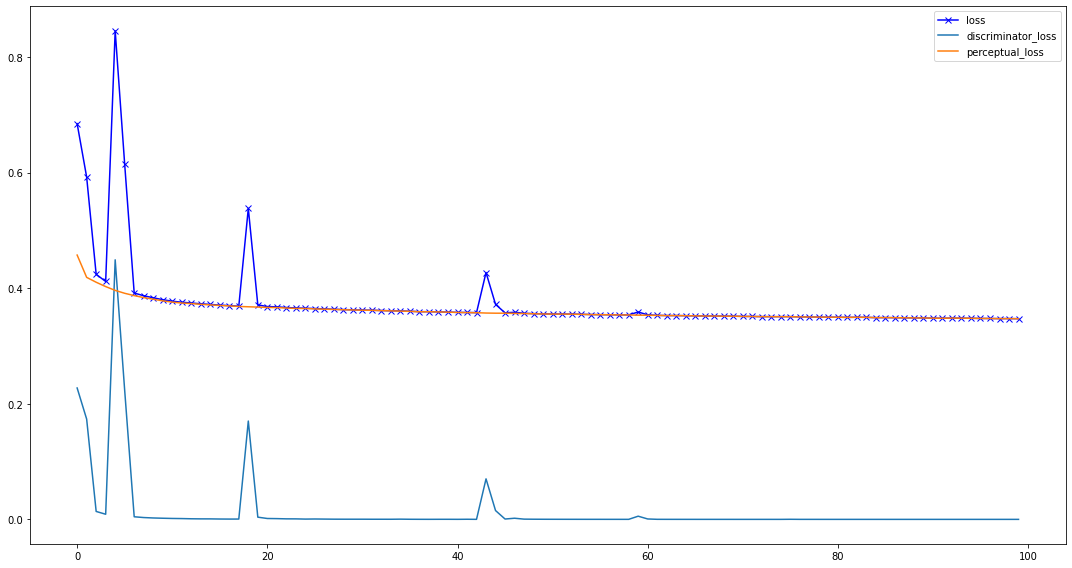

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(history["loss"], "-bx")
plt.plot(history["disc_loss"])
plt.plot(history["perc_loss"])
plt.legend(["loss", "discriminator_loss", "perceptual_loss"])
plt.tight_layout()
plt.show()

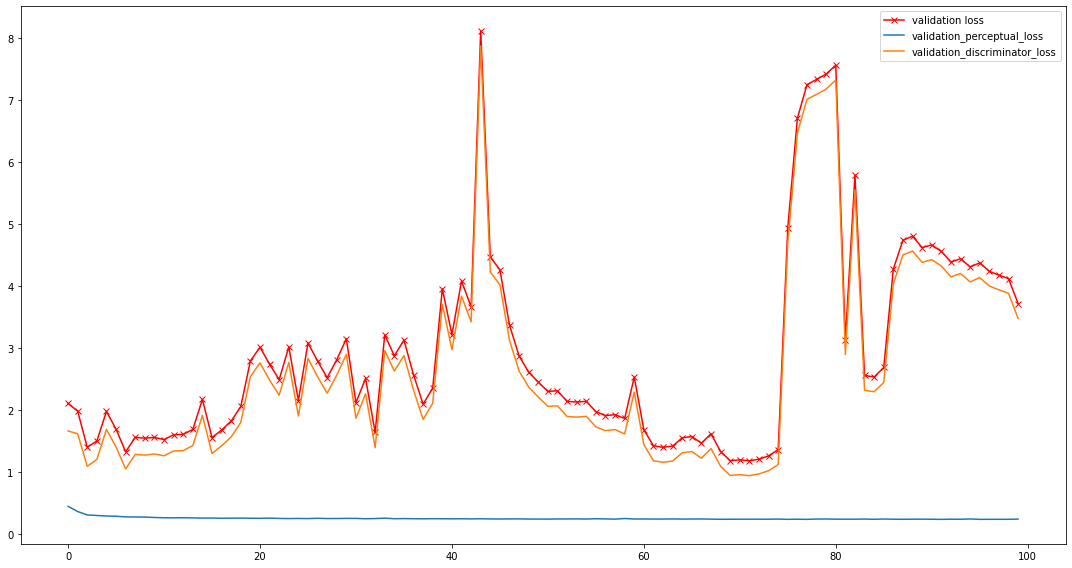

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(history["val_loss"], "-rx")
plt.plot(history["val_perc_loss"])
plt.plot(history["val_disc_loss"])
plt.legend(["validation loss", "validation_perceptual_loss", "validation_discriminator_loss"])
plt.tight_layout()
plt.show()

### Qualitative evaluation

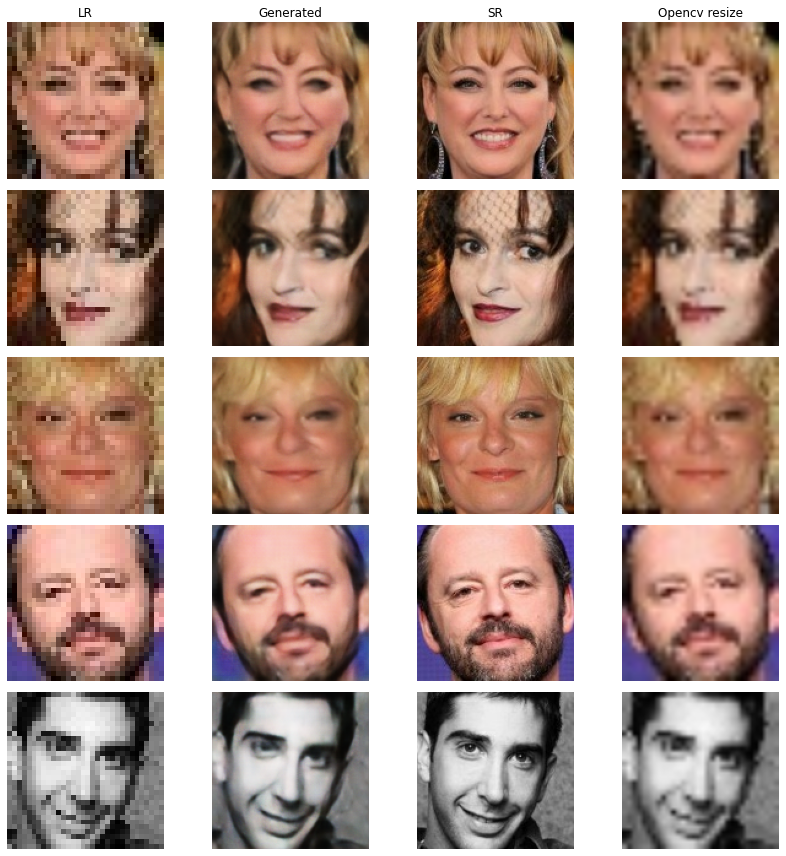

In [ ]:
#@title Train set
gan.plot_results(list(train_canny_dataset.unbatch().take(5)))

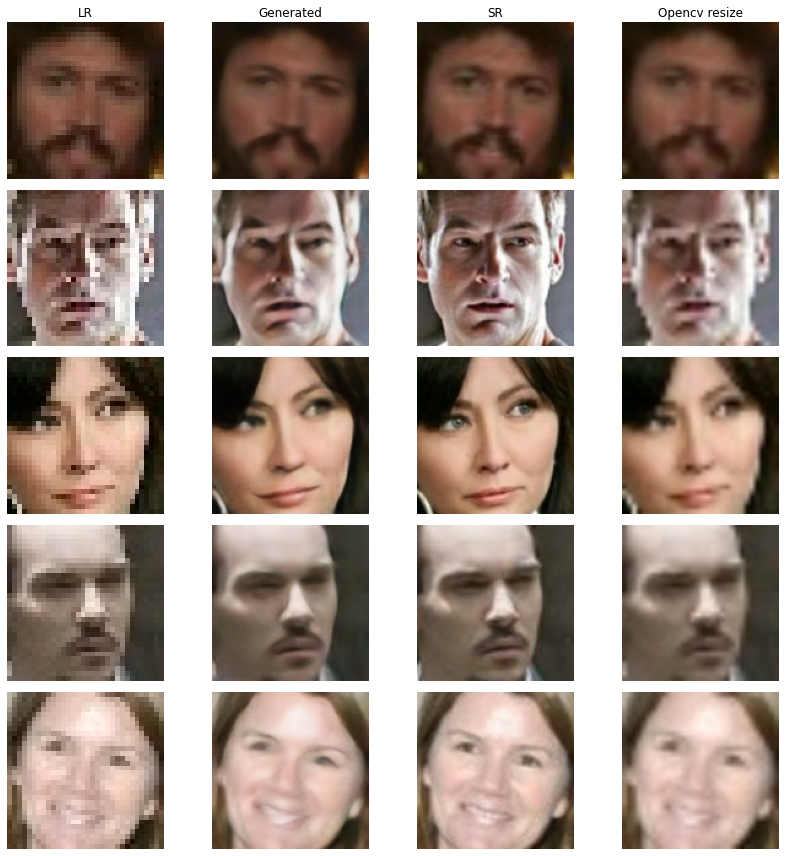

In [ ]:
#@title Test set
gan.plot_results(list(test_canny_dataset.unbatch().take(5)))

### Save model

In [ ]:
gan.save_weights()

In [ ]:
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
current_date = datetime.now().strftime("%Y-%m-%d")
!zip -r results-{current_time}.zip weights weights-{current_date}_* logs history

In [ ]:
# Automatically download the weights at the end of the training
from google.colab import files
filename = "results-{}.zip".format(current_time)
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Load model

In [ ]:
!gdown -q https://drive.google.com/uc?id=1bEKq-ct7jtMo_oztXLhBBl-rhGvYLhXP
!unzip -qn results-2021-10-22_12-49-13.zip
gan = UpsamplingGAN(adversarial_loss_weight=0.0001, content_loss_weight=1, lr=1e-4, inspect_image_steps=157, weights="weights-2021-10-22_10-55-44")

In [ ]:
!gdown -q https://drive.google.com/uc?id=1V5V0L9kEONdmGf9OGc_jiAqU8Yjc4E7R
!unzip -qn results-canny-2021-11-22_17-06-28.zip
canny_gan = UpsamplingGANCanny(adversarial_loss_weight=0.0001, content_loss_weight=1, lr=1e-4, inspect_image_steps=157, weights="weights")

## Models comparison

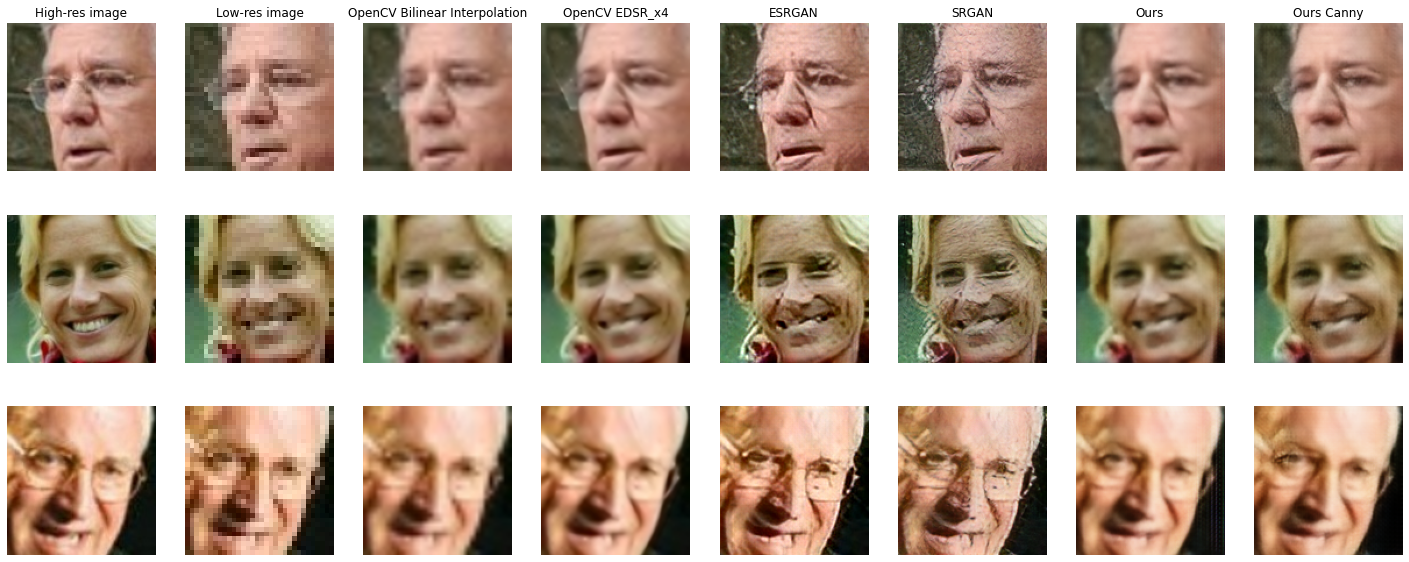

In [ ]:
#@markdown Super-Resolution Comparison
plt.figure(figsize=(25, 10))

num = np.random.randint(0, 41)
zipped_datasets = zip(cropped_lfw.shuffle(1024, seed=num).take(3), cropped_lfw_small.shuffle(1024, seed=num).take(3))
i = 0
for data, data_small in zipped_datasets:
  images, labels = data
  small_images, small_labels = data_small

  test_image = images[0].numpy().astype(np.uint8)
  test_small_image = small_images[0].numpy().astype(np.uint8)

  # Original image
  plt.subplot(3, 8, i * 8 + 1)
  if i == 0: plt.title("High-res image")
  plt.axis("off")
  plt.imshow(test_image)

  # Small image
  plt.subplot(3, 8, i * 8 + 2)
  if i == 0: plt.title("Low-res image")
  plt.axis("off")
  plt.imshow(test_small_image)

  # OpenCV upscaled
  plt.subplot(3, 8, i * 8 + 3)
  if i == 0: plt.title("OpenCV Bilinear Interpolation")
  plt.axis("off")
  resized = cv.resize(test_small_image, dsize=None, fx=4, fy=4)
  plt.imshow(resized)

  # SR upscaled
  plt.subplot(3, 8, i * 8 + 4)
  if i == 0: plt.title("OpenCV EDSR_x4")
  plt.axis("off")
  result_edsr = upsample_edsr(test_small_image)
  plt.imshow(result_edsr)

  plt.subplot(3, 8, i * 8 + 5)
  if i == 0: plt.title("ESRGAN")
  plt.axis("off")
  result_esrgan = upsample_esrgan(test_small_image)
  plt.imshow(result_esrgan)

  plt.subplot(3, 8, i * 8 + 6)
  if i == 0: plt.title("SRGAN")
  plt.axis("off")
  result_srgan = upsample_srgan(test_small_image)
  plt.imshow(result_srgan)

  plt.subplot(3, 8, i * 8 + 7)
  if i == 0: plt.title("Ours")
  plt.axis("off")
  result_ours = gan.upscale_image((test_small_image - 127.5) / 127.5)[0]
  result_ours = (result_ours * 127.5 + 127.5).numpy().astype(np.uint8)
  plt.imshow(result_ours)

  plt.subplot(3, 8, i * 8 + 8)
  if i == 0: plt.title("Ours Canny")
  plt.axis("off")
  result_ours_canny = canny_gan.upscale_image((test_small_image - 127.5) / 127.5)[0]
  result_ours_canny = (result_ours_canny * 127.5 + 127.5).numpy().astype(np.uint8)
  plt.imshow(result_ours_canny)

  i += 1

plt.show()

# Face Recognition

In this section we will define our face recognition model.

## Model definition

In [ ]:
# Add drive in order to save the results
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
identities = cropped_webface_train_ds.class_names
print("Identities:", len(identities))
print("First 5 identities:", identities[:5])

Identities: 1000


['0000045', '0000099', '0000100', '0000102', '0000103']

In [ ]:
base_model = tf.keras.applications.resnet.ResNet50(input_shape=(None, None, 3), include_top=False, weights="imagenet")

In [ ]:
base_model.trainable = True

inputs = tf.keras.Input(shape=(None, None, 3))
x = tf.keras.applications.resnet50.preprocess_input(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(len(identities), activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
tf.__operators__.getitem_3 ( (None, None, None, 3)     0         
_________________________________________________________________
tf.nn.bias_add_3 (TFOpLambda (None, None, None, 3)     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1000)              2049000   
Total params: 25,636,712
Trainable params: 25,583,592
Non-trainable params: 53,120
__________________________________________

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

## Model Training

In [ ]:
history = model.fit(cropped_webface_train_ds, epochs=10, validation_data=cropped_webface_validate_ds)

Epoch 1/10
313/313 [==============================] - 201s 502ms/step - loss: 6.5315 - acc: 0.0143 - val_loss: 7.5031 - val_acc: 0.0140
Epoch 2/10
313/313 [==============================] - 155s 493ms/step - loss: 5.9416 - acc: 0.0291 - val_loss: 6.2507 - val_acc: 0.0220
Epoch 3/10
313/313 [==============================] - 154s 493ms/step - loss: 5.5114 - acc: 0.0477 - val_loss: 8.8221 - val_acc: 0.0300
Epoch 4/10
313/313 [==============================] - 155s 494ms/step - loss: 5.1143 - acc: 0.0731 - val_loss: 6.1187 - val_acc: 0.0450
Epoch 5/10
313/313 [==============================] - 155s 494ms/step - loss: 4.6450 - acc: 0.1131 - val_loss: 6.3421 - val_acc: 0.0760
Epoch 6/10
313/313 [==============================] - 154s 493ms/step - loss: 4.1077 - acc: 0.1716 - val_loss: 5.5833 - val_acc: 0.1100
Epoch 7/10
313/313 [==============================] - 154s 493ms/step - loss: 3.4973 - acc: 0.2523 - val_loss: 5.4757 - val_acc: 0.1300
Epoch 8/10
313/313 [============================

In [ ]:
# Save history to file
with open("history.json", "w") as f:
  json.dump(history.history, f)

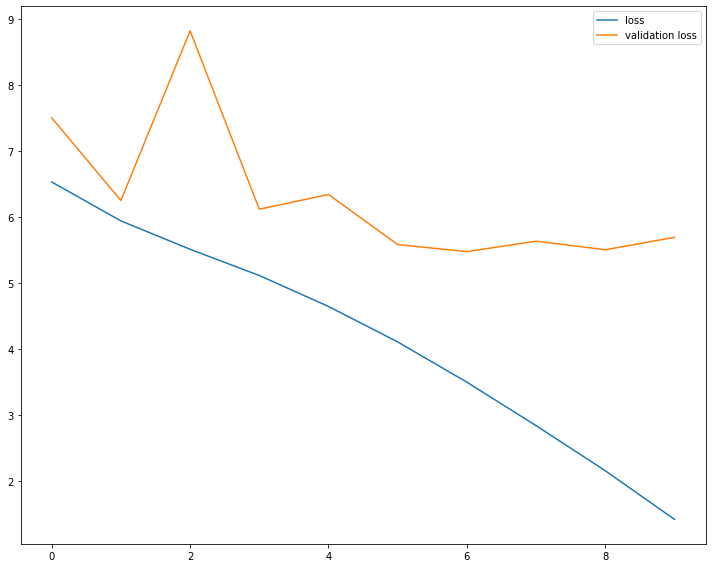

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "validation loss"])
plt.tight_layout()
plt.savefig("loss.png")
plt.show()

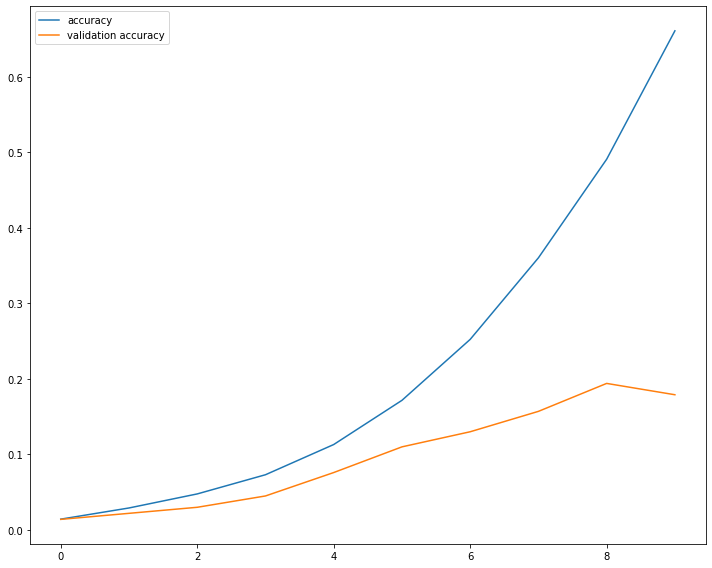

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.legend(["accuracy", "validation accuracy"])
plt.tight_layout()
plt.savefig("accuracy.png")
plt.show()

## Save model

In [ ]:
model_name = "resnet-imagenet-trainable-1000x128x128-10_epochs (Final)"
model.save(model_name)

In [ ]:
output = model_name + ".zip"
!zip -r "$output" "$model_name"

  adding: resnet-imagenet-trainable-1000x128x128-10_epochs (Final)/ (stored 0%)
  adding: resnet-imagenet-trainable-1000x128x128-10_epochs (Final)/variables/ (stored 0%)
  adding: resnet-imagenet-trainable-1000x128x128-10_epochs (Final)/variables/variables.index (deflated 77%)
  adding: resnet-imagenet-trainable-1000x128x128-10_epochs (Final)/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: resnet-imagenet-trainable-1000x128x128-10_epochs (Final)/assets/ (stored 0%)
  adding: resnet-imagenet-trainable-1000x128x128-10_epochs (Final)/saved_model.pb (deflated 92%)
  adding: resnet-imagenet-trainable-1000x128x128-10_epochs (Final)/keras_metadata.pb (deflated 96%)


In [ ]:
target = os.path.join(r"/content/03 - Models", model_name)
os.mkdir(target)
shutil.copy(output, os.path.join(target, output))
shutil.copy("history.json", os.path.join(target, "history.json"))
shutil.copy("loss.png", os.path.join(target, "loss.png"))
shutil.copy("accuracy.png", os.path.join(target, "accuracy.png"))
shutil.copy("model.png", os.path.join(target, "model.png"))

## Load model

In [ ]:
#@title Download best model
!gdown -q https://drive.google.com/uc?id=1-3sWnSb46R4tjoix490_cBfwYoJ5E-Ko
!unzip -qn "resnet-imagenet-trainable-1000x128x128-10_epochs (Final).zip"

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("resnet-imagenet-trainable-1000x128x128-10_epochs (Final)")
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 tf.__operators__.getitem_3   (None, None, None, 3)    0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, None, None, 3)    0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

## Inspect results

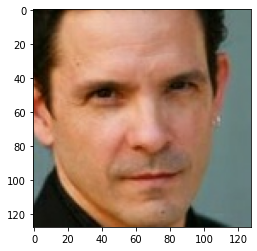

Predicted 0004971
True 0004968


In [ ]:
images, labels = next(iter(cropped_webface_train_ds))
i = 0
plt.imshow(images[i].numpy().astype(np.uint8))
plt.show()

prediction = model.predict(np.array([images[i]]))
identity = np.argmax(prediction[0])

print("Predicted", identities[identity])
print("True", identities[labels[i]])

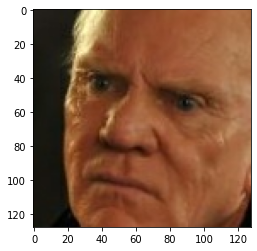

Predicted 0000102
True 0000532


In [ ]:
import random
images, labels = next(iter(cropped_webface_validate_ds))
i = int(random.random() * len(images))

plt.imshow(images[i].numpy().astype(np.uint8))
plt.show()

prediction = model.predict(np.array([images[i]]))

identity = np.argmax(prediction[0])

print("Predicted", identities[identity])
print("True", identities[labels[i]])

# Upscaling datasets

In this section we upscale the datasets with different methods (Bilinear interpolation, GAN, Canny GAN) and we save them to the disk in order to use them later.

In [ ]:
def upscale_dataset(dataset, upscale_fn, save_dir):
  """ 
  Upscale an entire dataset to `target_size` using `upscale_fn` to upscale an image
  and saving the results in `save_dir`.
  """
  total_size = len(dataset.file_paths)

  # Remove previous directory if exists
  if os.path.exists(save_dir):
    import shutil
    shutil.rmtree(save_dir)
  
  os.mkdir(save_dir)

  i = 0
  for images, labels in dataset:
    upscaled_images = []

    # Crop images for a batch
    for image, label in zip(images, labels):
      if i % 10 == 0:
        progress_bar = get_progress_bar(i, total_size)
        percent = int(i / total_size * 100)
        print("\r%s%% %s Upscaling and saving to disk %d/%d..." % (percent, progress_bar, i, total_size), end="")

      upscaled_image = upscale_fn(image)
      upscaled_images.append(upscaled_image)

      image_path = dataset.file_paths[i]
      orig_folder = os.path.basename(os.path.dirname(image_path))
      path = os.path.join(save_dir, orig_folder)
      if not os.path.exists(path):
        os.makedirs(path)
        
      filename = os.path.basename(image_path)
      cv.imwrite(os.path.join(path, filename), upscaled_image)
      
      i += 1

  progress_bar = get_progress_bar(len(dataset), len(dataset))
  print("\r%s%% %s Upscaled with success %d images" % (100, progress_bar, total_size))

def opencv_upscale(size):
  def _resize(image):
    uint_image = image.numpy().astype(np.uint8)
    bgr_image = cv.cvtColor(uint_image, cv.COLOR_BGR2RGB)
    return cv.resize(bgr_image, size)
  return _resize

def gan_upscale(model):
  def _resize(image):
    image = (image - 127.5) / 127.5
    upscaled_image = model.upscale_image(image)[0]
    uint_image = (upscaled_image * 127.5 + 127.5).numpy().astype(np.uint8)
    return cv.cvtColor(uint_image, cv.COLOR_BGR2RGB)
  return _resize

In [ ]:
upscale_dataset(cropped_lfw_small, opencv_upscale((128, 128)), "lfw-upscaled-opencv")

100% [====================] Upscaled with success 13190 images


In [ ]:
upscale_dataset(cropped_lfw_small, gan_upscale(gan), "lfw-upscaled-gan")

100% [====================] Upscaled with success 13190 images


In [ ]:
upscale_dataset(cropped_lfw_small, gan_upscale(canny_gan), "lfw-upscaled-canny-gan")

100% [====================] Upscaled with success 13190 images


In [ ]:
!zip -qr lfw-upscaled-128-opencv.zip lfw-upscaled-opencv
!zip -qr lfw-upscaled-128-gan.zip lfw-upscaled-gan
!zip -qr lfw-upscaled-128-canny-gan.zip lfw-upscaled-canny-gan

In [ ]:
!cp lfw-upscaled-128-opencv.zip "/content/01 - Dataset"
!cp lfw-upscaled-128-gan.zip "/content/01 - Dataset"
!cp lfw-upscaled-128-canny-gan.zip "/content/01 - Dataset"

# Evaluation

In this section we evaluate the performances of our models. Moreover, we compare the results of our model with the VGG-Face, implemented in the [DeepFace](https://github.com/serengil/deepface) package of Python.

In [ ]:
!pip -q install deepface
from deepface import DeepFace

     |████████████████████████████████| 61 kB 3.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.3 MB 11.4 MB/s 
Directory  /root /.deepface created
Directory  /root /.deepface/weights created


In [ ]:
#@title Download upscaled datasets
files = {
  "lfw-upscaled-128-opencv.zip": "19c75BhfAY38-7f4FG4abVJ74VObg8TTE",
  "lfw-upscaled-128-gan.zip": "1UgBlWdoxOfIhv8QEFXrFkPqmy0W1WgIG",
  "lfw-upscaled-128-canny-gan.zip": "1FOxXcDo5iJDSTIOkBLpduneKjukWObZ3",
}

download_datasets(files)

Unzipping...Done.
Unzipping...Done.
Unzipping...Done.


In [ ]:
DATASET_NAME = "lfw-upscaled-canny-gan" #@param ["cropped-lfw-32", "cropped-lfw-128", "lfw-upscaled-opencv", "lfw-upscaled-gan", "lfw-upscaled-canny-gan"]

In [ ]:
evaluation_dataset = tf.keras.preprocessing.image_dataset_from_directory("/content/" + DATASET_NAME, image_size=(32, 32) if DATASET_NAME == "cropped-lfw-32" else (128, 128), shuffle=False)
print("Loaded dataset", DATASET_NAME)

Found 13190 files belonging to 5733 classes.
Loaded dataset lfw-upscaled-canny-gan


In [ ]:
MODEL_NAME = "Ours" #@param ["Ours", "VGG-Face"]

### Precompute templates

In [ ]:
# Get the size of the dataset
total = len(evaluation_dataset.file_paths)

imgs, _ = next(iter(evaluation_dataset))
w, h, c = imgs[0].shape

templates = np.zeros((total, 2048 if MODEL_NAME == "Ours" else 2622))
images = np.zeros((total, w, h, c))
labels = []

# The following dict is going to contain the name of the identities
# and for each of them there is going to be another mapping
# that given the number of an image is going to retrieve the index of
# that image in the previously defined vectors
# e.g. { Identity -> n.img -> index in the templates, images, labels vectors}
identities_mapping = {}

i = 0

# Create a new model without the last two layers in order to obtain the templates as output
template_model = tf.keras.Model(model.input, model.layers[-2].output)

last_i = 0
last_time = time.time()
delta = 0

for batch_images, batch_labels in evaluation_dataset:
  # Get the file names
  file_names = evaluation_dataset.file_paths[i:i+len(batch_images)]
  
  # Obtain the templates for the images
  if MODEL_NAME != "Ours":
    out_templates = [DeepFace.represent(image.numpy().astype(np.uint8), model_name=MODEL_NAME, enforce_detection=False) for image in batch_images]
    out_templates = np.array(out_templates)
  else:
    out_templates = template_model.predict(batch_images)
  
  templates[i:i+len(batch_images)] = out_templates
  images[i:i+len(batch_images)] = batch_images

  # Get the identities from the labels
  identities = [evaluation_dataset.class_names[l] for l in batch_labels]
  labels += identities

  for j in range(len(identities)):
    identity = identities[j]
    file_name = os.path.basename(file_names[j])

    if identity not in identities_mapping:
      identities_mapping[identity] = {}
  
    # Compute the number of template from the filename and add it to the mapping
    name_without_ext = os.path.splitext(file_name)[0]
    num_template = int(name_without_ext.split("_")[-1])
    identities_mapping[identity][num_template] = i

    i += 1

  if time.time() - last_time >= 1:
    delta = i - last_i
    last_time = time.time()
    last_i = i
    print("\r", get_progress_bar(i, total), "{}/{}".format(i, total), delta, "images/sec", end="")

labels = np.array(labels)

print("\r", get_progress_bar(total, total), "{}/{}".format(total, total), delta, "images/sec")

 [====================] 13190/13190 166 images/sec


### Compute distance matrix

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

M = 1 - cosine_similarity(templates, templates)
M

array([[-4.44089210e-16,  5.56458370e-01,  5.79176651e-01, ...,
         6.09935542e-01,  4.95559560e-01,  6.15345655e-01],
       [ 5.56458370e-01,  7.77156117e-16,  5.80914136e-01, ...,
         5.90723417e-01,  7.19234455e-01,  5.20391624e-01],
       [ 5.79176651e-01,  5.80914136e-01, -4.44089210e-16, ...,
         6.71825498e-01,  5.28797303e-01,  4.57737465e-01],
       ...,
       [ 6.09935542e-01,  5.90723417e-01,  6.71825498e-01, ...,
         0.00000000e+00,  6.46745203e-01,  5.74045384e-01],
       [ 4.95559560e-01,  7.19234455e-01,  5.28797303e-01, ...,
         6.46745203e-01, -4.44089210e-16,  4.84896043e-01],
       [ 6.15345655e-01,  5.20391624e-01,  4.57737465e-01, ...,
         5.74045384e-01,  4.84896043e-01, -2.22044605e-16]])

We fill the diagonal with `inf` since we want to ignore the distance with the same template which will be always 0.
In this way when we will sort the distances, the distance with itself will be the last one and we will be able to efficiently remove that just using the `pop()` method.

In [ ]:
np.fill_diagonal(M, np.inf)
M.round(2)

array([[ inf, 0.56, 0.58, ..., 0.61, 0.5 , 0.62],
       [0.56,  inf, 0.58, ..., 0.59, 0.72, 0.52],
       [0.58, 0.58,  inf, ..., 0.67, 0.53, 0.46],
       ...,
       [0.61, 0.59, 0.67, ...,  inf, 0.65, 0.57],
       [0.5 , 0.72, 0.53, ..., 0.65,  inf, 0.48],
       [0.62, 0.52, 0.46, ..., 0.57, 0.48,  inf]])

## All-Against-All

Based on the code provided during the lectures, in this section, we perform the All-Against-All validation method using the LFW dataset.

### Evaluation

In [ ]:
thresholds = np.arange(0, 1 + .05, .05)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [ ]:
def find_k(distances, L, label, th, same_label=True):
  """
  Find the rank of the first identity which has a score below the threshold
  and label equal to the one provided or diffrent from it, according to the same_label argument.
  """
  for k in range(1, len(L)):
    index = L[k]
    distance = distances[index]
    if distance > th:
      return None
    if same_label and labels[index] == label:
      return k
    if not same_label and labels[index] != label:
      return k
  return None

TG = TI = len(labels)

num_thresholds = len(thresholds)

DIR = np.zeros((num_thresholds, len(labels)+1))
FRR = np.zeros((num_thresholds))
FAR = np.zeros((num_thresholds))
GRR = np.zeros((num_thresholds))

total_size = num_thresholds * len(M)

for th_index, t in enumerate(thresholds):
  DI = [0 for _ in range(len(labels) + 1)]
  GR = 0
  FA = 0

  for i in range(len(M)):

    if i % 100 == 0:
      index = th_index * len(M) + i
      progress_bar = get_progress_bar(index, total_size)
      percent = int(index / total_size * 100)
      print("\r%s%% %s Computing All-Against-All %d/%d %d/%d..." % (percent, progress_bar, th_index, num_thresholds, i, len(M)), end="")

    label = labels[i]

    L = np.argsort(M[i])

    first_subject_index = L[0]
    first_subject_distance = M[i][first_subject_index]
    first_subject_label = labels[first_subject_index]

    if first_subject_distance <= t:
      if first_subject_label == label:
        # Genuine case
        DI[1] += 1

        # Impostor case (gallery without true identity)
        if find_k(M[i], L, label, t, same_label=False):
          FA += 1
      else:
        # Genuine case
        k = find_k(M[i], L, label, t, same_label=True)
        if k:
          DI[k + 1] += 1

        # Impostor case
        FA += 1
    else:
      GR += 1
  
  DIR[th_index, 1] = DI[1] / TG
  FRR[th_index] = 1 - DIR[th_index, 1]
  FAR[th_index] = FA / TI
  GRR[th_index] = GR / TI

  # Compute DIR for other ranks
  for k in range(2, len(DI)):
    DIR[th_index, k] = DI[k] / TG + DIR[th_index, k-1]

progress_bar = get_progress_bar(total_size, total_size)
print("\r%s%% %s Computing All-Against-All %d/%d %d/%d..." % (100, progress_bar, num_thresholds, num_thresholds, len(M), len(M)))

RR = DIR[:, 1]

print("Detection and Identification:")
print(DIR.round(2), "\n")

print("Recognition Rate:")
print(RR.round(2), "\n")

print("False Rejection Rate:")
print(FRR.round(2), "\n")

print("False Acceptance Rate:")
print(FAR.round(2), "\n")

print("Genuine Rejection Rate:")
print(GRR.round(2), "\n")

100% [====================] Computing All-Against-All 21/21 13190/13190...
Detection and Identification:
[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.01 0.01 ... 0.01 0.01 0.01]
 ...
 [0.   0.33 0.38 ... 0.69 0.69 0.69]
 [0.   0.33 0.38 ... 0.69 0.69 0.69]
 [0.   0.33 0.38 ... 0.69 0.69 0.69]] 

Recognition Rate:
[0.   0.   0.01 0.1  0.24 0.32 0.33 0.33 0.33 0.33 0.33 0.33 0.33 0.33
 0.33 0.33 0.33 0.33 0.33 0.33 0.33] 

False Rejection Rate:
[1.   1.   0.99 0.9  0.76 0.68 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67
 0.67 0.67 0.67 0.67 0.67 0.67 0.67] 

False Acceptance Rate:
[0.   0.   0.   0.01 0.27 0.81 0.98 1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.  ] 

Genuine Rejection Rate:
[1.   1.   0.99 0.89 0.59 0.15 0.02 0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.  ] 



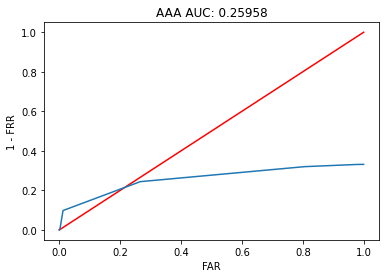

In [ ]:
from sklearn.metrics import auc

auc_score = auc(FAR, RR)

plt.plot([0, 1], [0, 1], color="r")
plt.plot(FAR, RR)
plt.xlabel("FAR")
plt.ylabel("1 - FRR")
plt.title("AAA AUC: {:.5f}".format(auc_score))
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.savefig("all_against_all_auc.png")
plt.show()

In [ ]:
index = np.nanargmin(np.absolute(FRR - FAR))
EER = FRR[index]
best_th_aaa = thresholds[index]
best_th_aaa, EER

(0.25, 0.6799848369977255)

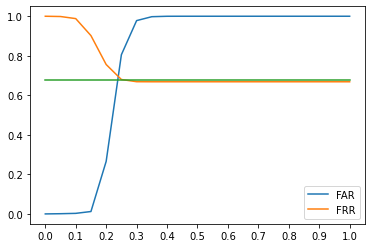

In [ ]:
plt.plot(thresholds, FAR, label="FAR")
plt.plot(thresholds, FRR, label="FRR")
plt.xticks(np.arange(0, 1.1, .1))
plt.plot(thresholds, [EER for _ in range(len(thresholds))])
plt.legend()
plt.show()

In [ ]:
print("Recognition Rate (DIR@1):", DIR[index, 1].round(2))
print("DIR@5:", DIR[index, 5].round(2))
print("DIR@10:", DIR[index, 10].round(2))
print("DIR@20:", DIR[index, 20].round(2))
print("DIR@40:", DIR[index, 40].round(2))
print("FRR:", FRR[index].round(2))
print("FAR:", FAR[index].round(2))
print("GRR:", GRR[index].round(2))

Recognition Rate (DIR@1): 0.32
DIR@5: 0.4
DIR@10: 0.42
DIR@20: 0.43
DIR@40: 0.43
FRR: 0.68
FAR: 0.81
GRR: 0.15


### Playground

Little playground to see how the model is performing with a random probe.

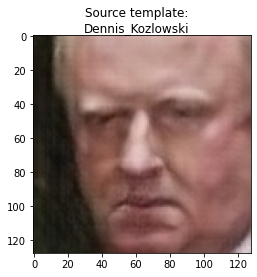

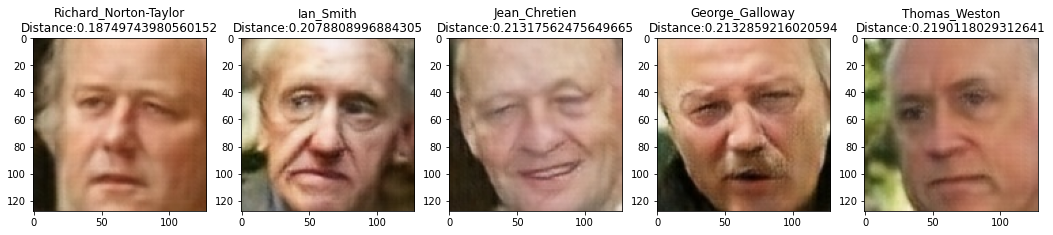

In [ ]:
i = np.random.randint(0, len(templates))
plt.suptitle("Source template:\n" + labels[i])
plt.imshow(images[i].astype(np.uint8))
plt.show()

similar_templates = np.argsort(M[i])
plt.figure(figsize=(18, 8))
for j in range(5):
  plt.subplot(1, 5, j+1)
  idx = similar_templates[j]
  plt.imshow(images[idx].astype(np.uint8))
  plt.title(labels[idx] + "\nDistance:" + str(M[i][idx]))
plt.show()

## Standard LFW Evaluation

Since there is a specific protocol for evaluating models performances on the LFW dataset, we decided to evalutate our methods also with this one. It consists in checking if the model can correctly recognize if a pair of templates belong to the same identity or they are two different people.

So, first of all let's download the file containing the test set (pairs):

In [ ]:
!wget http://vis-www.cs.umass.edu/lfw/pairs.txt

--2021-11-28 14:39:02--  http://vis-www.cs.umass.edu/lfw/pairs.txt
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155335 (152K) [text/plain]
Saving to: ‘pairs.txt’

pairs.txt           100%[===================>] 151.69K  --.-KB/s    in 0.1s    

2021-11-28 14:39:02 (1.03 MB/s) - ‘pairs.txt’ saved [155335/155335]



Let's now parse it in order to make it easier to work with that:

In [ ]:
def parse_pairs(path):
  with open(path) as file:
    folds = []
    first_line = file.readline().split()
    # The first line contains the number of folds and the number of records in each fold.
    # Each fold contains the same number of matched and mismatched pairs.
    # This means that a fold contains n_records * 2 records in total.
    n_folds, n_records = int(first_line[0]), int(first_line[1])
    for n_fold in range(n_folds):
      fold = []
      # Matched pairs
      # Since the identities match, it's only indicated the identity and the two numbers of the templates
      for i in range(n_records):
        data = file.readline().split()
        label, img1, img2 = data[0], int(data[1]), int(data[2])
        fold.append((1, (label, img1, img2)))
      # Mismatched pairs
      # It's indicated the two identities and the two numbers of the templates
      for i in range(n_records):
        data = file.readline().split()
        label, img1, label2, img2 = data[0], int(data[1]), data[2], int(data[3])
        fold.append((0, (label, img1, label2, img2)))
      folds.append(fold)
  return folds

folds = parse_pairs("pairs.txt")
print("Number of folds:", len(folds))
print("Number of records for each fold:", len(folds[0]))
folds[0][:5]

Number of folds: 10
Number of records for each fold: 600


[(1, ('Abel_Pacheco', 1, 4)),
 (1, ('Akhmed_Zakayev', 1, 3)),
 (1, ('Akhmed_Zakayev', 2, 3)),
 (1, ('Amber_Tamblyn', 1, 2)),
 (1, ('Anders_Fogh_Rasmussen', 1, 3))]

### Evaluation

In [ ]:
from sklearn.metrics import auc
thresholds = np.arange(0, 1 + .05, .05)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

Fold [1] 	 auc_score: 0.9315 	 best_accuracy: 0.8717 	 best_threshold: 0.6000
Fold [2] 	 auc_score: 0.9012 	 best_accuracy: 0.8617 	 best_threshold: 0.6000
Fold [3] 	 auc_score: 0.9222 	 best_accuracy: 0.8583 	 best_threshold: 0.6000
Fold [4] 	 auc_score: 0.8799 	 best_accuracy: 0.8317 	 best_threshold: 0.6000
Fold [5] 	 auc_score: 0.8990 	 best_accuracy: 0.8400 	 best_threshold: 0.6000
Fold [6] 	 auc_score: 0.8953 	 best_accuracy: 0.8467 	 best_threshold: 0.6000
Fold [7] 	 auc_score: 0.9341 	 best_accuracy: 0.8967 	 best_threshold: 0.6000
Fold [8] 	 auc_score: 0.9056 	 best_accuracy: 0.8500 	 best_threshold: 0.6000
Fold [9] 	 auc_score: 0.9111 	 best_accuracy: 0.8633 	 best_threshold: 0.6000
Fold [10] 	 auc_score: 0.9537 	 best_accuracy: 0.8950 	 best_threshold: 0.6000

Results - mean_accuracy: 0.8615 best_threshold: 0.6000



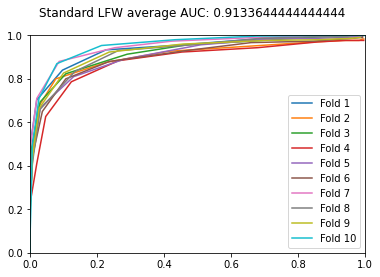

In [ ]:
AUCS = []
accuracies = []

for i, fold in enumerate(folds):
  TPS = []
  FPS = []
  TNS = []
  FNS = []
  for th in thresholds:
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for record in fold:
      label, data = record
      if label == 1:
        # Matching pair
        identity, num_template1, num_template2 = data

        try:
          identity_templates = identities_mapping[identity]
          template1_id = identity_templates[num_template1]
          template2_id = identity_templates[num_template2]

          cos = 1 - M[template1_id][template2_id]
          if cos >= th:
            TP += 1
          else:
            FN += 1
        except KeyError:
          # We didn't detect a face, so we consider this case as an error
          # since the system would reject the person
          FN += 1
      else:
        # Mismatched pair
        identity1, num_template1, identity2, num_template2 = data

        try:
          template1_id = identities_mapping[identity1][num_template1]
          template2_id = identities_mapping[identity2][num_template2]
          cos = 1 - M[template1_id][template2_id]
          if cos >= th:
            FP += 1
          else:
            TN += 1
        except KeyError:
          # We didn't detect a face, so in this case we output false, 
          # since the system is going to reject the person
          TN += 1
    TPS.append(TP)
    FPS.append(FP)
    TNS.append(TN)
    FNS.append(FN)
  
  TPS = np.array(TPS)
  FPS = np.array(FPS)
  TNS = np.array(TNS)
  FNS = np.array(FNS)

  TPRS = TPS / (TPS + FNS)
  FPRS = FPS / (FPS + TNS)
  
  plt.plot(FPRS, TPRS, label="Fold " + str(i+1))
  plt.xlim(0, 1)
  plt.ylim(0, 1)
  
  auc_score = auc(FPRS, TPRS)
  accuracy = (TPS + TNS) / (TPS + FPS + TNS + FNS)

  best_acc = np.max(accuracy)
  best_th_lfw = thresholds[np.argmax(accuracy)]
  print("Fold [{}] \t auc_score: {:.4f} \t best_accuracy: {:.4f} \t best_threshold: {:.4f}".format(i+1, auc_score, best_acc, best_th_lfw))

  AUCS.append(auc_score)
  accuracies.append(accuracy)

print()
mean_acc = np.mean(accuracies, axis=0)
best_th_lfw = thresholds[np.argmax(mean_acc)]
print("Results - mean_accuracy: {:.4f} best_threshold: {:.4f}".format(np.max(mean_acc), best_th_lfw))
print()

plt.legend()
plt.suptitle("Standard LFW average AUC: " + str(np.mean(AUCS)))
plt.savefig("standard_lfw_auc.png")
plt.show()

## Save evaluation results

In [ ]:
import json

results = {
    "model": MODEL_NAME,
    "dataset": DATASET_NAME,
    "AllAgainstAll": {
        "DIR": DIR.tolist(),
        "FRR": FRR.tolist(),
        "FAR": FAR.tolist(),
        "GRR": GRR.tolist(),
        "RR": RR.tolist(),
        "EER": EER,
        "BestThreshold": best_th_aaa
    },
    "StandardLFW": {
        "TPS": TPS.tolist(),
        "FPS": FPS.tolist(),
        "TNS": TNS.tolist(),
        "FNS": TPS.tolist(),
        "TPRS": TPRS.tolist(),
        "FPRS": FPRS.tolist(),
        "AUCS": AUCS,
        "MeanAUC": np.mean(AUCS),
        "Accuracies": np.array(accuracies).tolist(),
        "MeanAccuracy": mean_acc.tolist(),
        "BestThreshold": best_th_lfw
    }
}

with open("evaluation_results.json", "w", encoding="utf-8") as fp:
  json.dump(results, fp)

!zip $MODEL_NAME"_"$DATASET_NAME"_evaluation_results.zip" "all_against_all_auc.png" "standard_lfw_auc.png" "evaluation_results.json"
!cp $MODEL_NAME"_"$DATASET_NAME"_evaluation_results.zip" "/content/04 - Results"

  adding: all_against_all_auc.png (deflated 5%)
  adding: standard_lfw_auc.png (deflated 3%)
  adding: evaluation_results.json (deflated 98%)
